In [2]:
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
import torch
import torch.nn as nn
import os
from typing import List, Dict, Any, Tuple

from tms.utils.utils import load_results
from tms.training.experiments import run_experiments
from tms.utils.utils import generate_sparsity_values
from tms.data.dataset import SyntheticBinaryValued
from tms.models.autoencoder import ToyAutoencoder
from tms.llc import estimate_llc, get_llc_data
from tms.plots.kgons import plot_losses_and_polygons


In [4]:
version = "1.13.0"
data_path = "../data"
results_1_13 = load_results(data_path, version)

# llc_estimates = estimate_llc(results, version)
llc_estimates_1_13 = get_llc_data(results_1_13, version, data_path)

In [5]:
version = "1.14.0"
data_path = "../data"
results_1_14 = load_results(data_path, version)

# llc_estimates = estimate_llc(results, version)
llc_estimates_1_14 = get_llc_data(results_1_14, version, data_path)

In [9]:
def compare_dataframes_and_results(df_results_pairs, positions = [9, 18, 27, 36, 45], hyperparam_combos = [(300, 0.001)], x_scale="linear", y_scale="linear", sharey=False, sharex=False, ymin=1e-4):
    warnings.simplefilter(action='ignore', category=UserWarning)  # Probably unwise

    for batch_size, learning_rate in hyperparam_combos:
        print(f"Batch size: {batch_size}, Learning rate: {learning_rate}\n")
        
        for position in positions:
            fig, axes = plt.subplots(1, len(df_results_pairs), figsize=(15*len(df_results_pairs), 10), sharey=sharey, sharex=sharex)
            if len(df_results_pairs) == 1:
                axes = [axes]

            for pair_index, (llc_estimates, results) in enumerate(df_results_pairs):
                llc_loss_by_sparsity = defaultdict(list)
                steps = results[0]['parameters']['log_ivl']
                
                for index in range(len(results)):
                    filtered_df = llc_estimates[llc_estimates['index'] == index]
                    llc = filtered_df[
                        (filtered_df['batch_size'] == batch_size) &
                        (filtered_df['lr'] == learning_rate) &
                        (filtered_df['snapshot_index'] == position) &
                        (filtered_df['t_sgld'] > 150) &
                        (filtered_df['llc_type'] != "mean")
                    ]["llc"].mean()
                    
                    loss = results[index]['logs']['loss'].values[position]
                    sparsity = results[index]['parameters']['sparsity']
                    llc_loss_by_sparsity[sparsity].append((llc, loss))

                for sparsity, llc_loss in llc_loss_by_sparsity.items():
                    if sparsity == 0:
                        continue
                    llcs = [llc for llc, loss in llc_loss if not(np.isnan(llc))]
                    losses = [loss for llc, loss in llc_loss if not(np.isnan(llc))]
                    if all(np.isnan(llc) for llc in llcs):
                        continue
                    axes[pair_index].scatter(*zip(*llc_loss), label=f"Sparsity: {round(sparsity,3)}")
                    if pair_index == 0:
                        title = "Initialized at random 4-gon"
                    if pair_index == 1:
                        title = "Initialized at optimal parameters for sparse inputs"
                    axes[pair_index].set_title(f"Pair {title}, Position {position}")
                    axes[pair_index].set_xlabel("LLC")
                    axes[pair_index].set_ylabel("Loss")
                    axes[pair_index].legend()
                    axes[pair_index].set_xscale(x_scale)
                    axes[pair_index].set_yscale(y_scale)
                    axes[pair_index].set_ylim(ymin=ymin)


            plt.tight_layout()
            plt.suptitle(f"Loss and LLC After Epoch {steps[position]}", fontsize=16)
            plt.subplots_adjust(top=0.9)
            #plt.savefig(f'../results/loss_vs_llc_epoch_{steps[position]}')
            plt.show()

In [10]:
high_sparsity_1_13 = llc_estimates_1_13[llc_estimates_1_13['index'] >= 400]
high_sparsity_1_14 = llc_estimates_1_14[llc_estimates_1_14['index'] >= 400]

Batch size: 300, Learning rate: 0.001



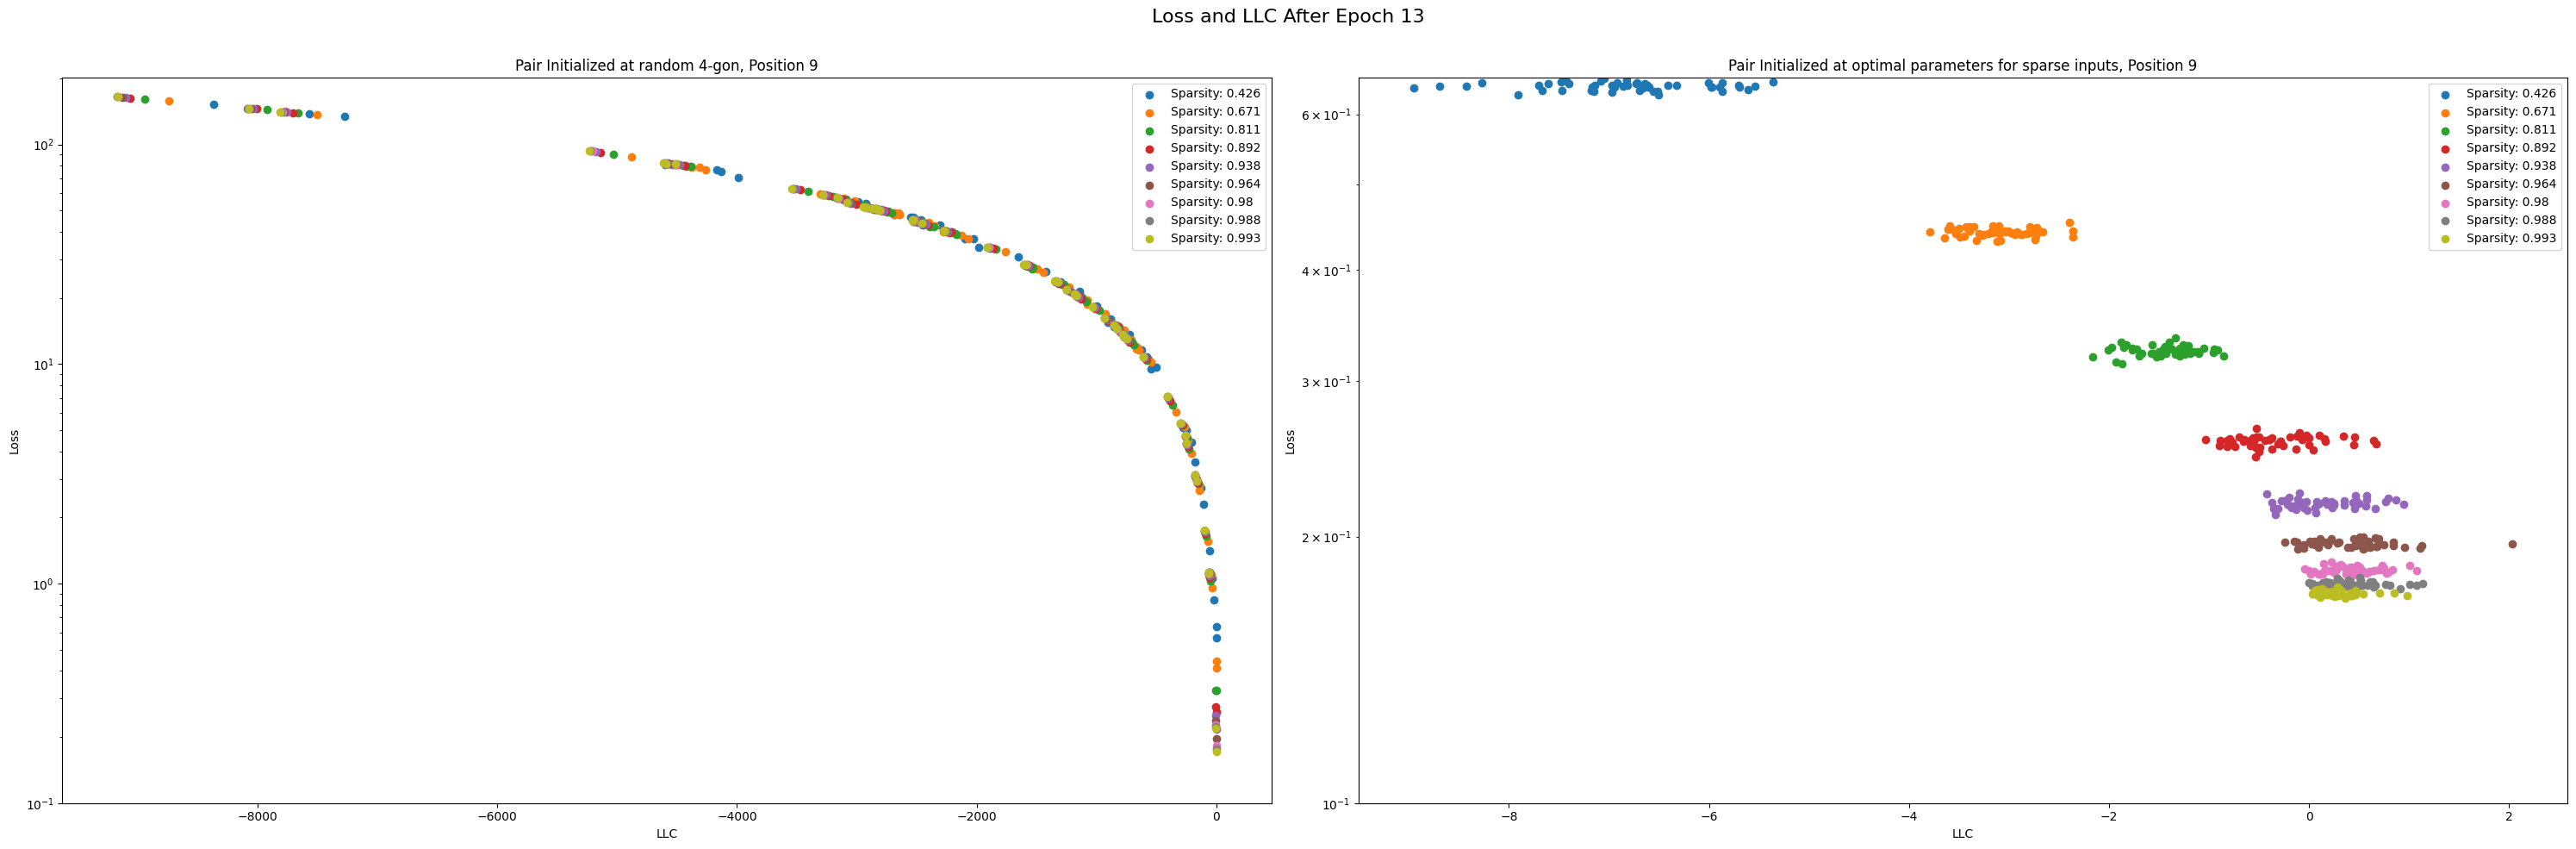

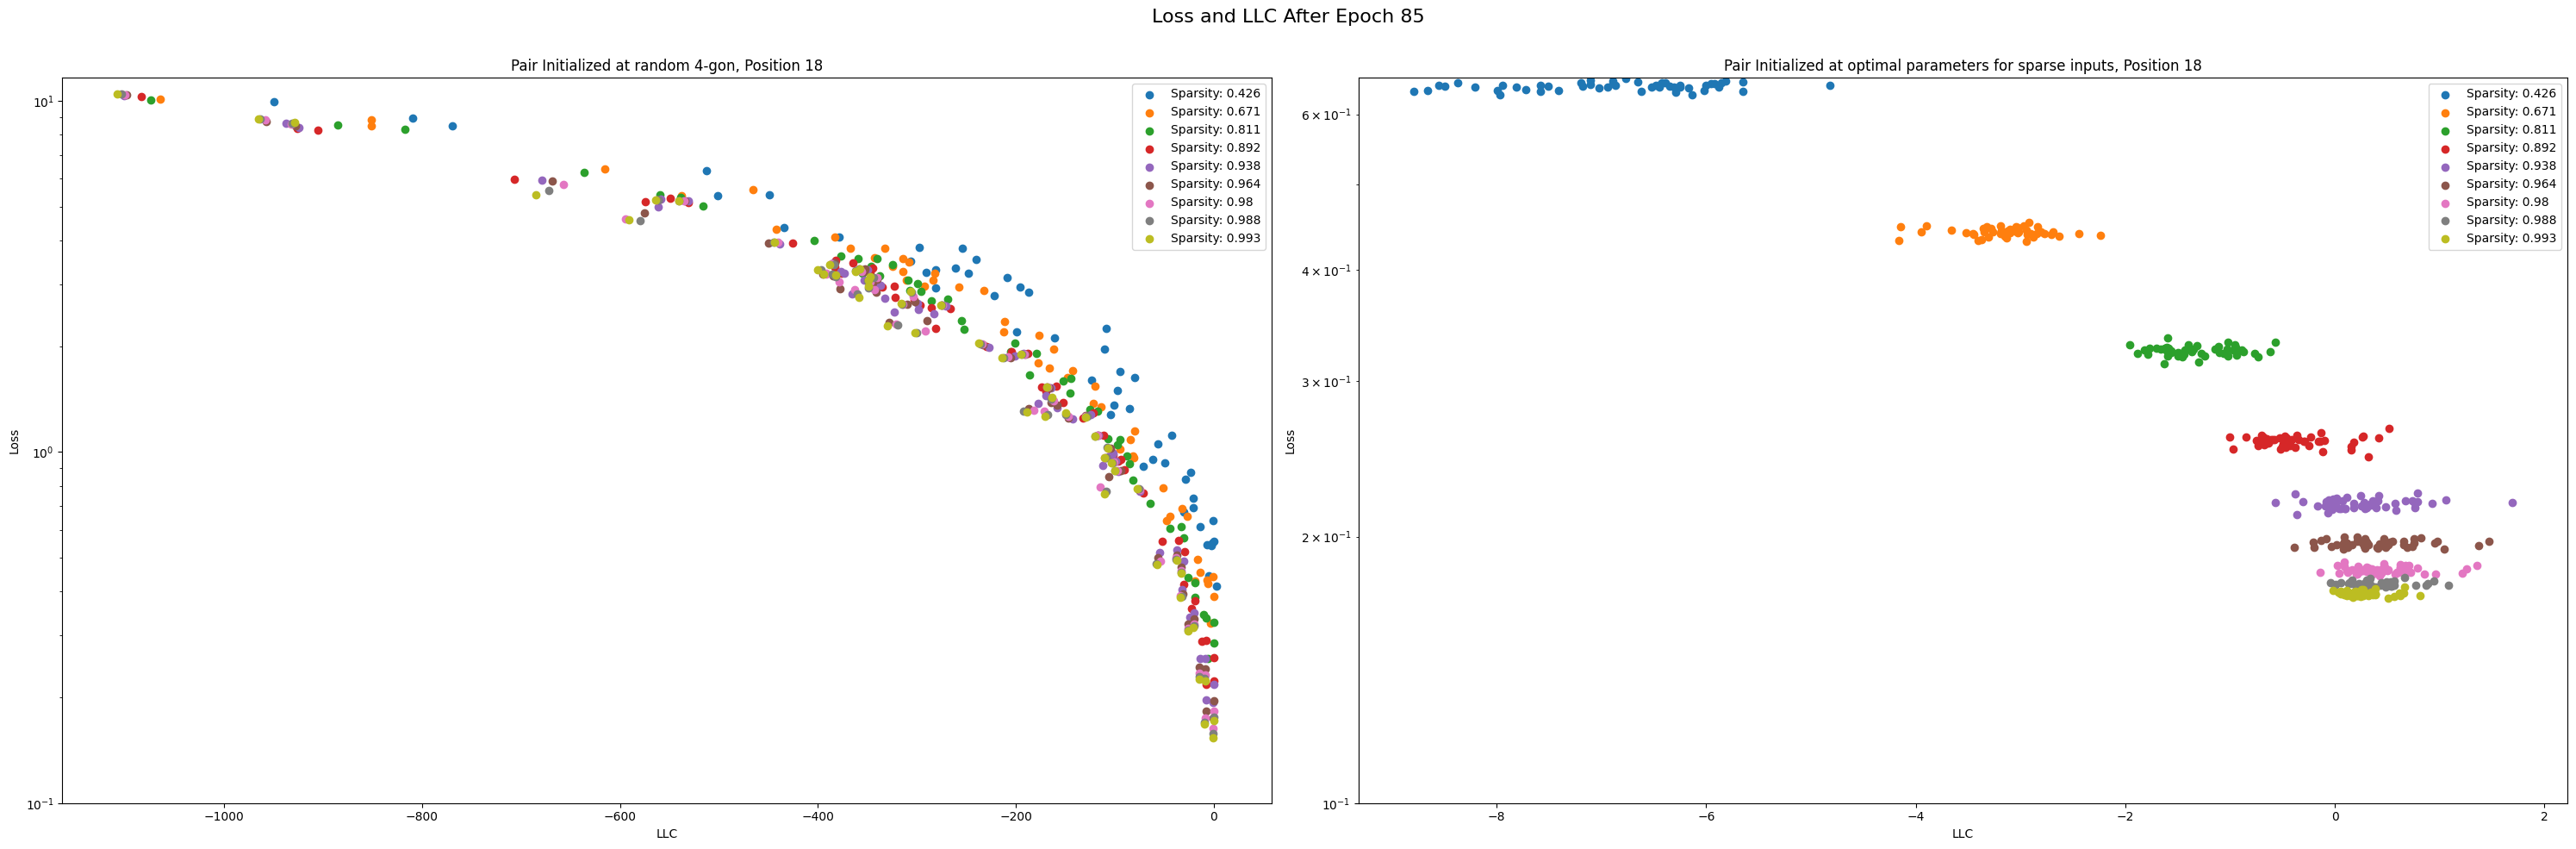

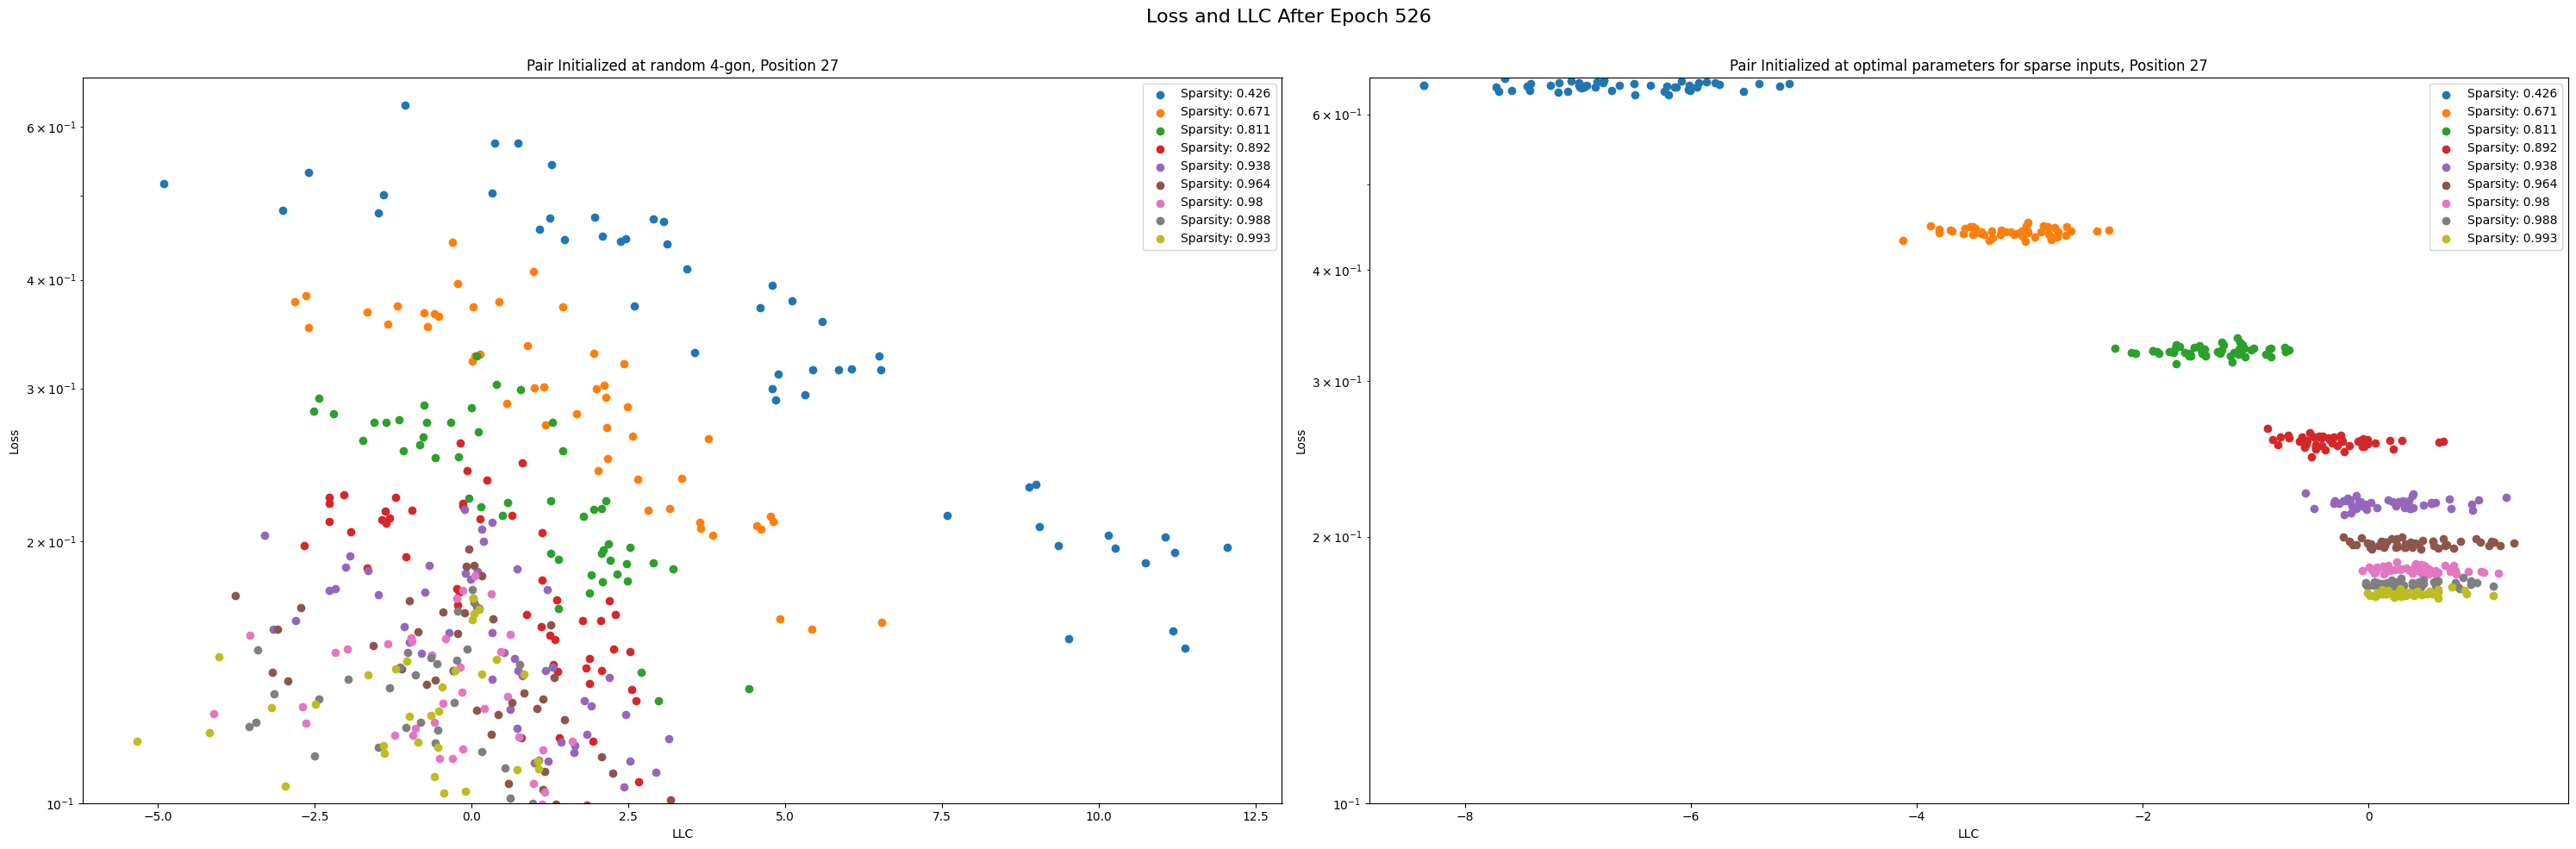

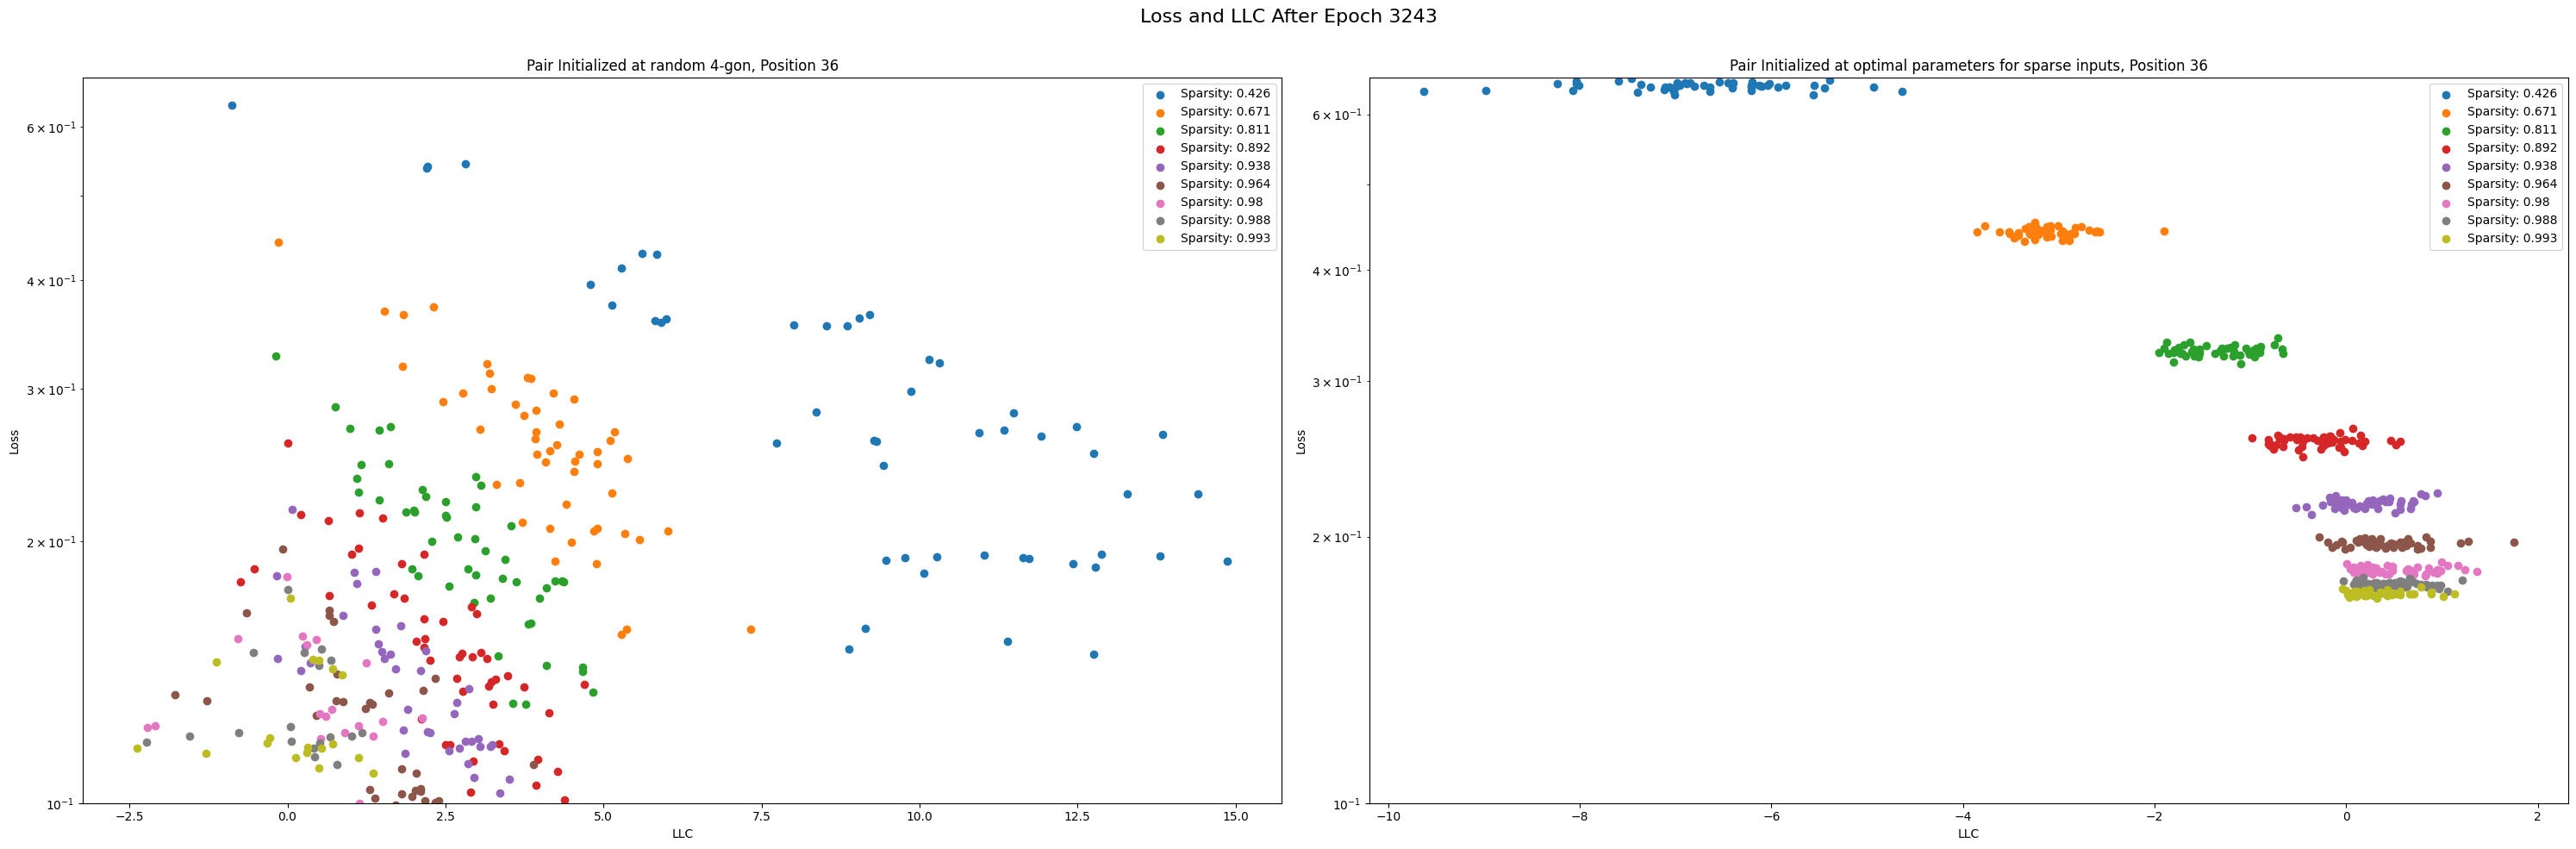

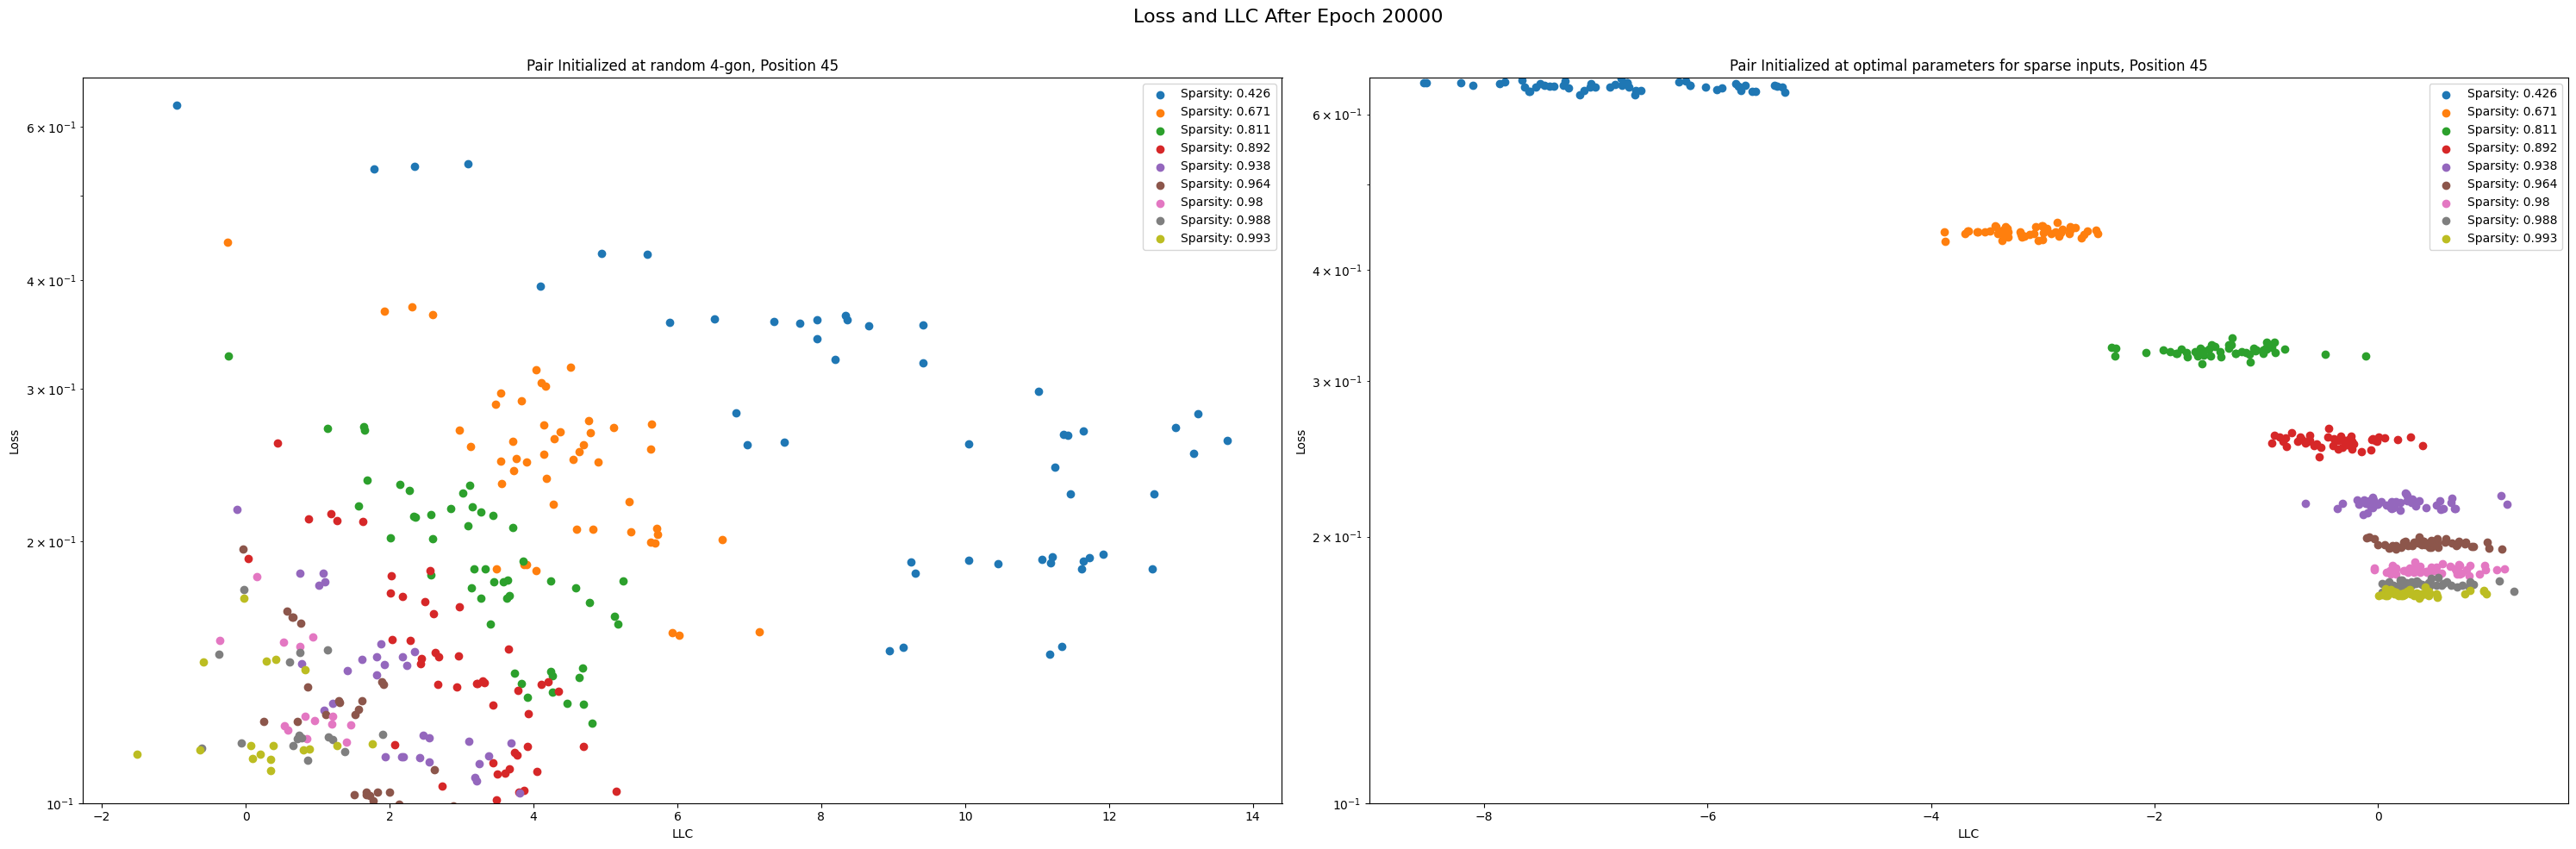

In [12]:
compare_dataframes_and_results([(llc_estimates_1_13, results_1_13), (llc_estimates_1_14, results_1_14)], hyperparam_combos=[(300, 0.001)], y_scale="log", ymin=1e-1)

Batch size: 300, Learning rate: 0.001



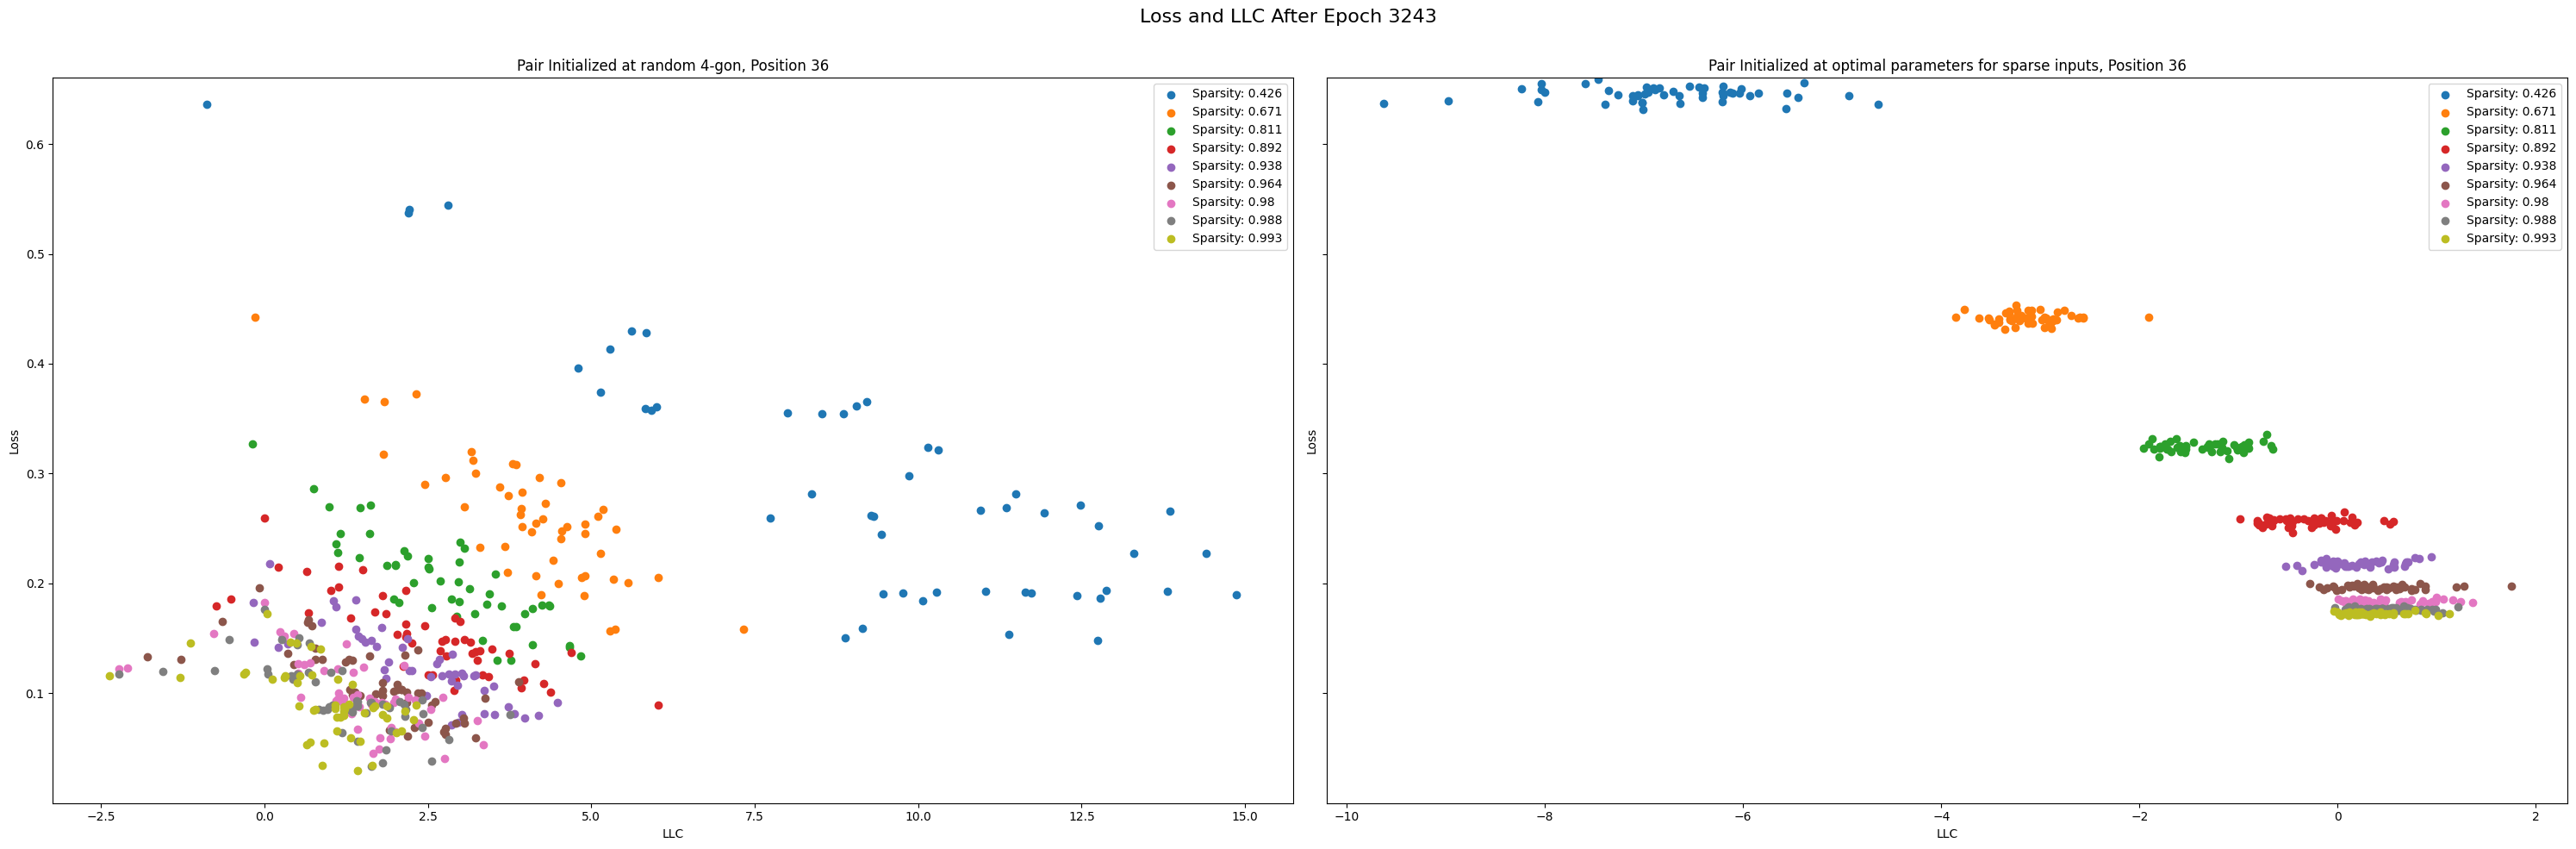

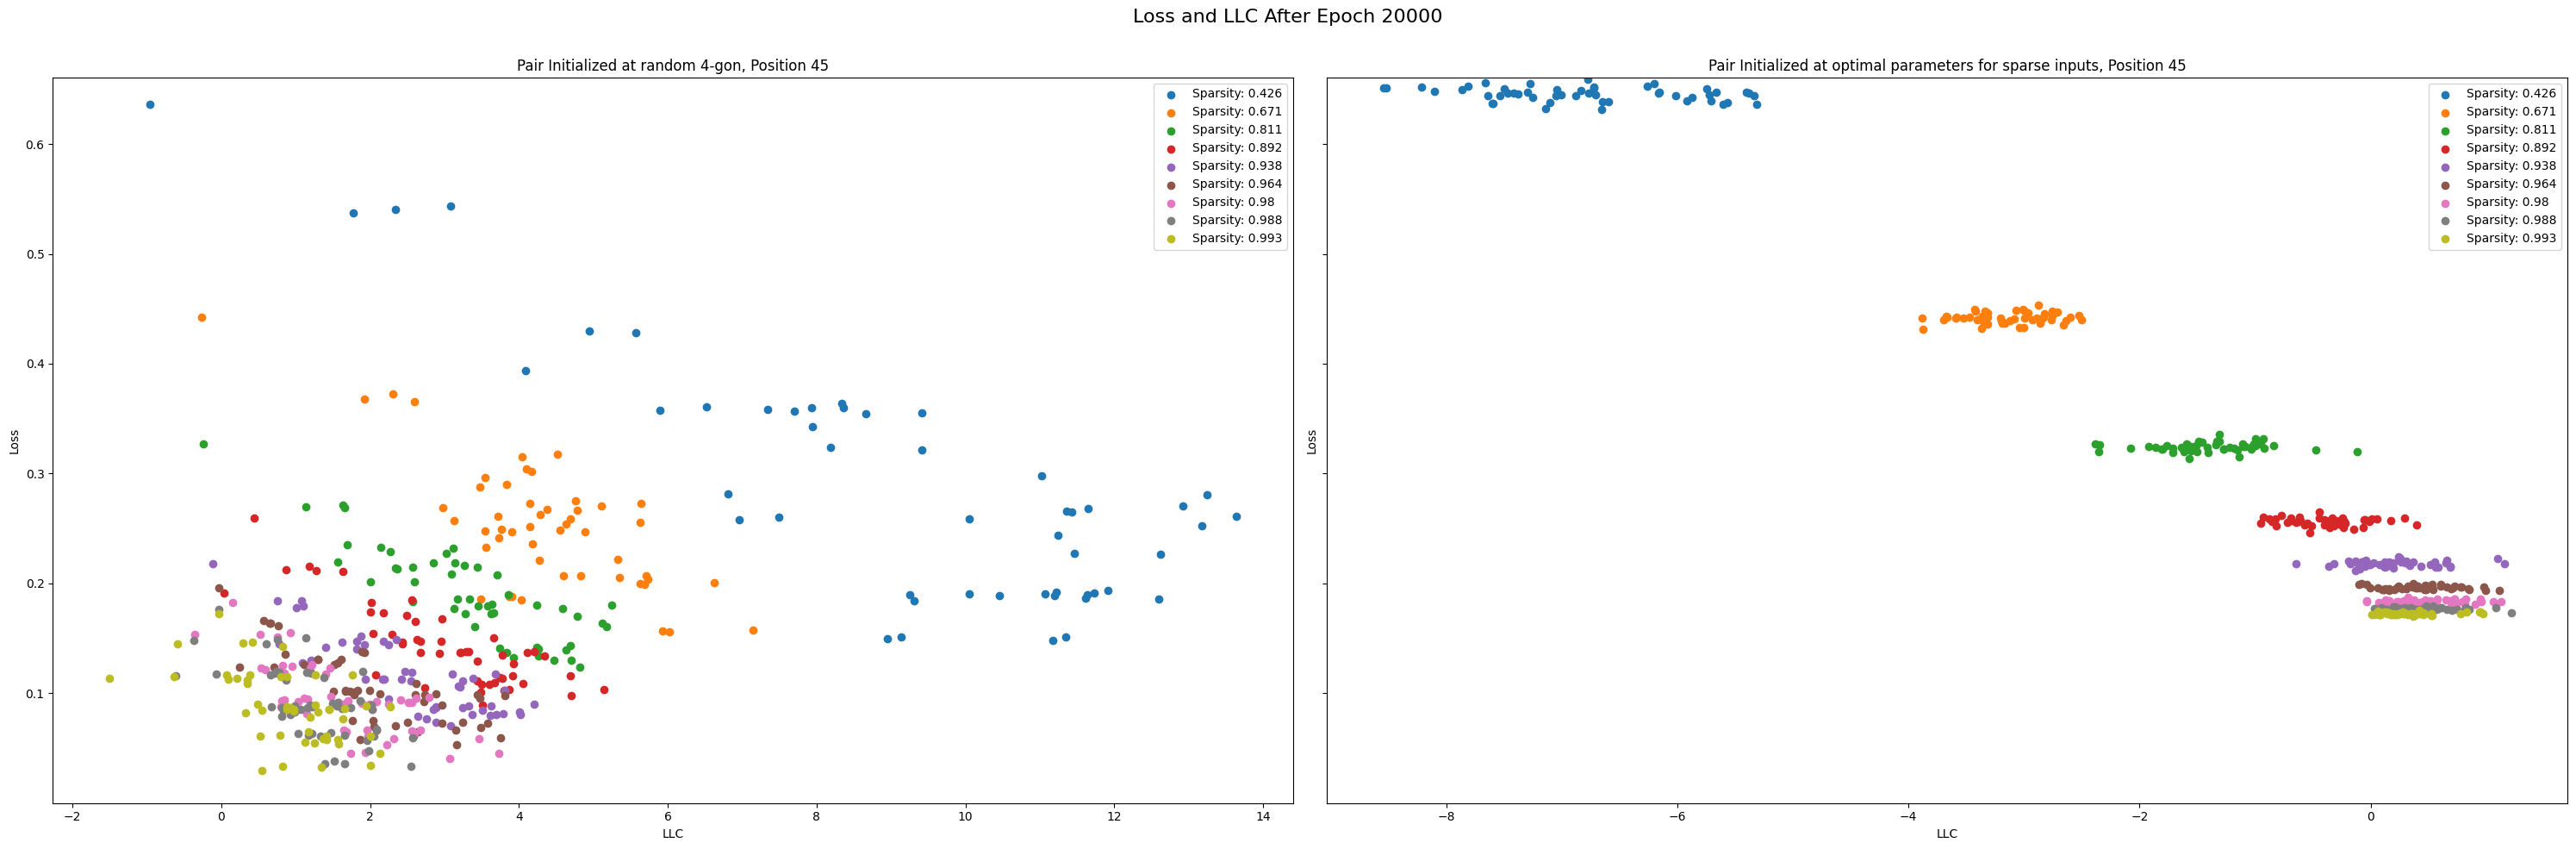

In [14]:
compare_dataframes_and_results([(llc_estimates_1_13, results_1_13), (llc_estimates_1_14, results_1_14)], positions=[36,45], hyperparam_combos=[(300, 0.001)], y_scale="linear", sharey=True)

In [15]:
def plot_results(results, plot_number =5, step =-1, loss_window = (0.14, .16), weird_indices = [], sparsities= [0.426, 0.671, 0.811, 0.892, 0.938, 0.964, 0.98 , 0.988, 0.993], epsilon=0.001):
    # loss_hist = []
    for sparse_value in sparsities:
        plotted =0
        print(f"Plot polygons for sparsity={sparse_value}")
        for index in range(len(results)):
            
            STEPS = results[index]['parameters']['log_ivl']
            logs = results[index]['logs']
            losses = [logs.loc[logs['step'] == s, 'loss'].values[0] for s in STEPS]

            outside_loss_window = losses[step] < loss_window[0] or losses[step] > loss_window[1]
            non_matching_sparsity = abs(results[index]['parameters']['sparsity'] - sparse_value) > epsilon
            if non_matching_sparsity or outside_loss_window:
                continue
            else:
                if plotted>=plot_number:
                    continue
                plotted+=1


            NUM_EPOCHS = 20000
            PLOT_STEPS = [min(STEPS, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, NUM_EPOCHS - 1]]
            PLOT_INDICES = [STEPS.index(s) for s in PLOT_STEPS]
            Ws = [results[index]['weights'][i]['embedding.weight'] for i in PLOT_INDICES]
            biases = [results[index]['weights'][i]['unembedding.bias'] for i in PLOT_INDICES]
            
            model = ToyAutoencoder(6, 2, final_bias=True)
            new_weights ={}
            for idx, ndarray in results[index]['weights'][PLOT_INDICES[-1]].items():
                new_weights[idx] = torch.from_numpy(ndarray)

            # criterion=nn.MSELoss()
        
            # model.load_state_dict(new_weights)

            # # print(sample)
            # # print(model(sample))
            # test_set = SyntheticBinaryValued(10000, 6, sparse_value)
            # mean_loss_test = 0
            # for sample in test_set:
            #     output = model(sample)
            #     mean_loss_test += criterion(output, sample)
            # # print("Mean loss test:")
            # loss_hist.append(mean_loss_test)
            # print(f"index: {index}")
            # print(mean_loss_test/10000)
            # # if mean_loss_test<20:
            # #     continue
            # # else:
            # #     weird_indices.append(index)
            

            #all_weights = [[results[j]['weights'][i] for i in PLOT_INDICES] for j in range(len(results))]
            plot_losses_and_polygons(STEPS, losses, PLOT_STEPS, Ws, biases)
            plt.show()

Plot polygons for sparsity=0.993


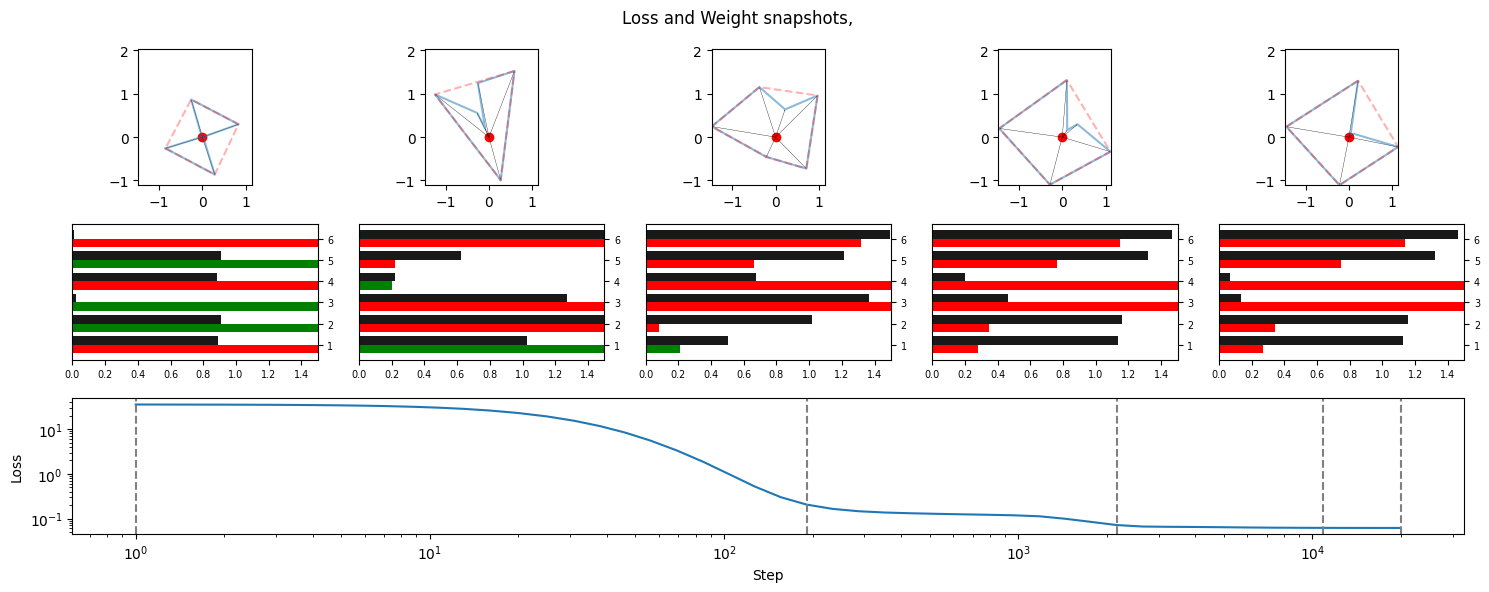

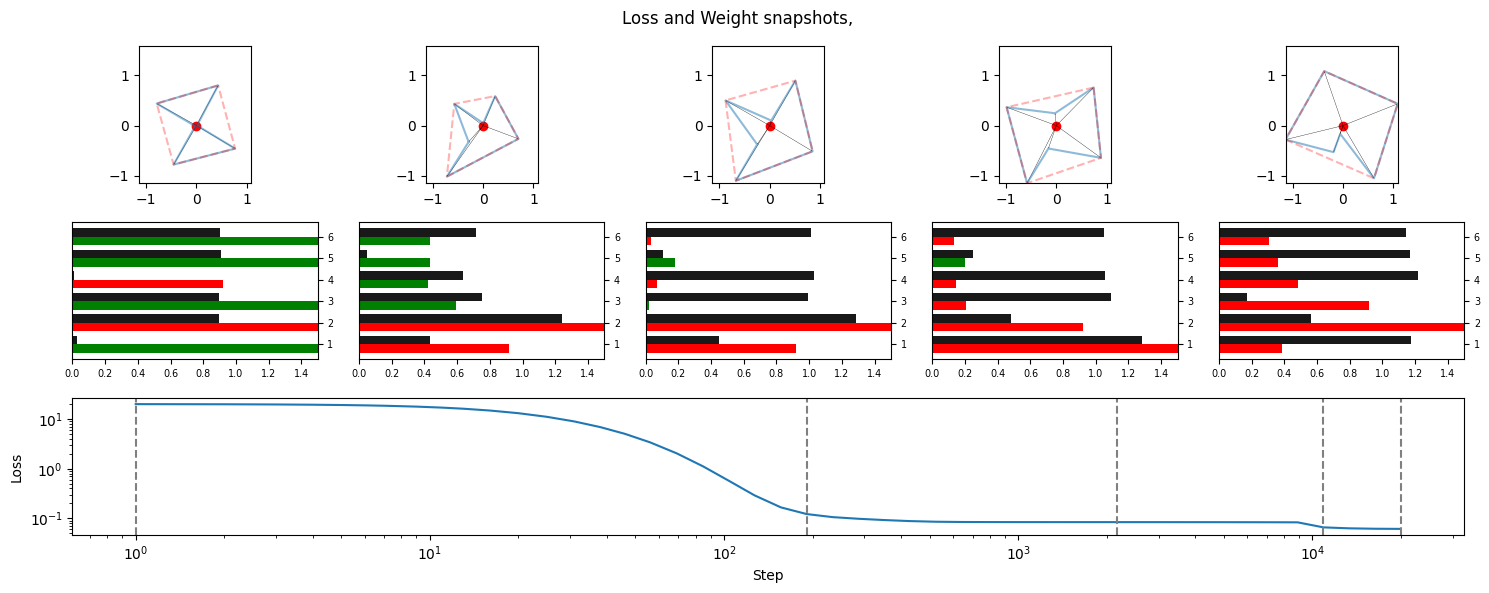

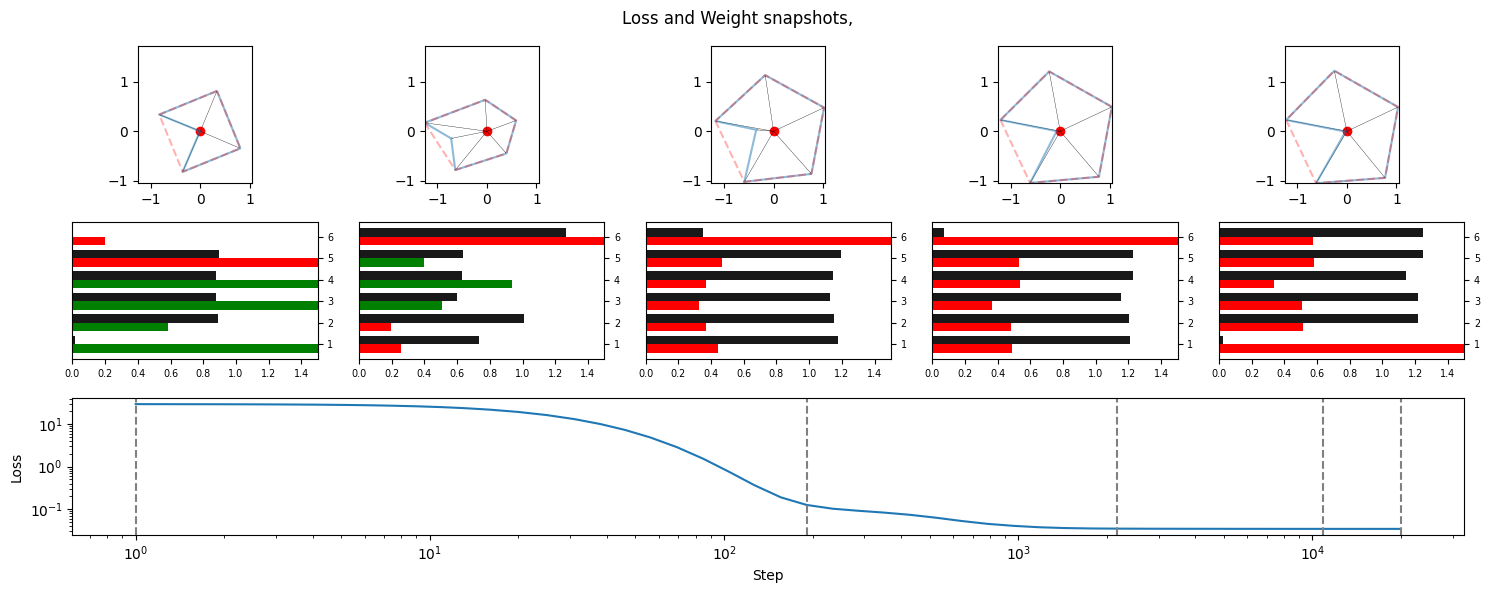

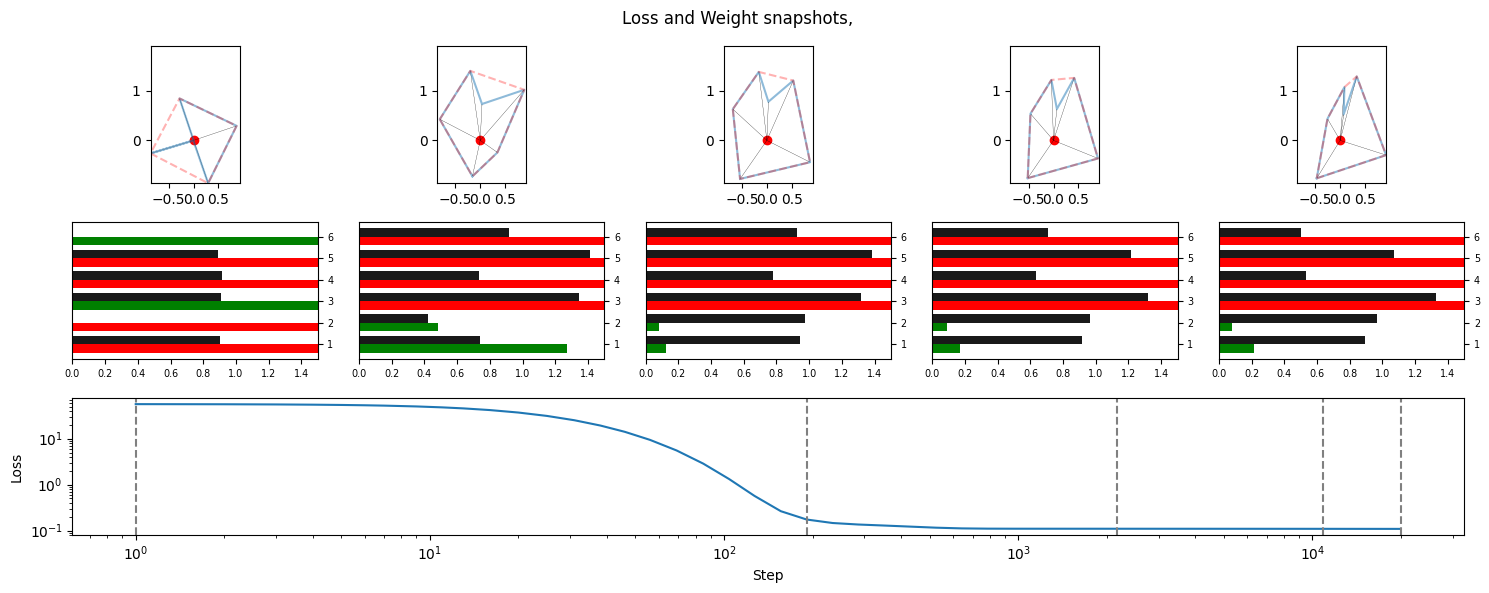

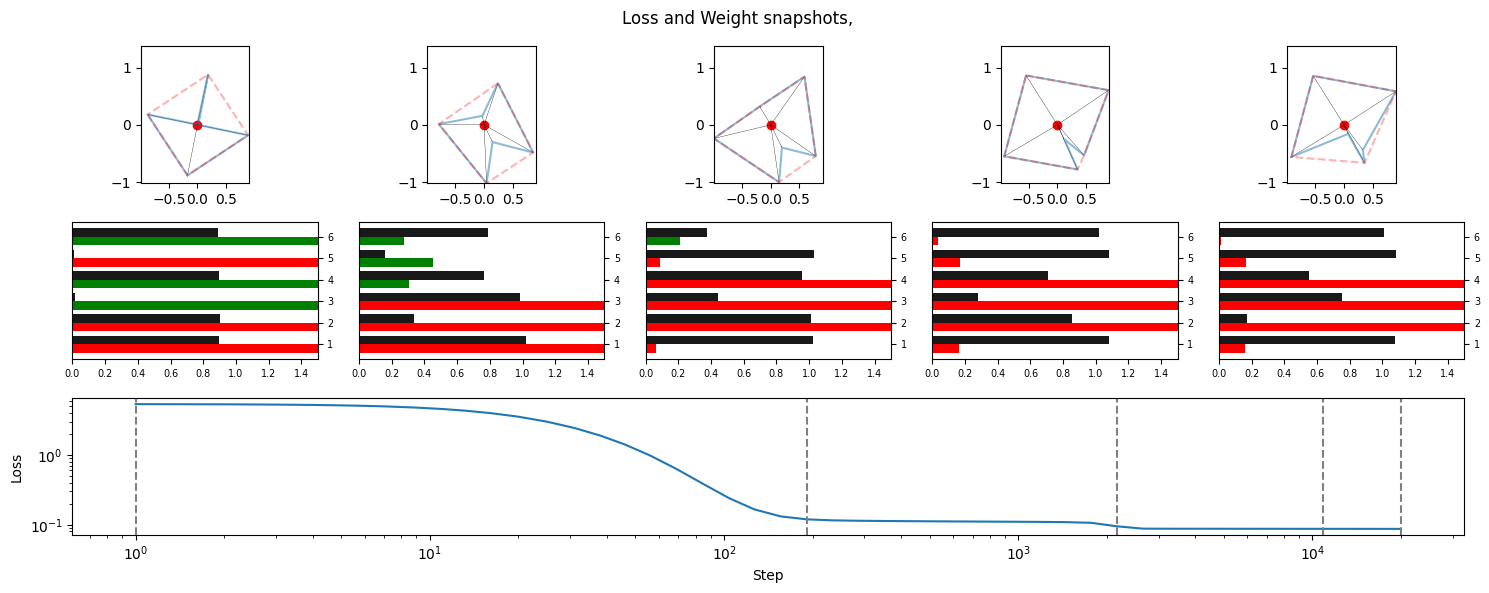

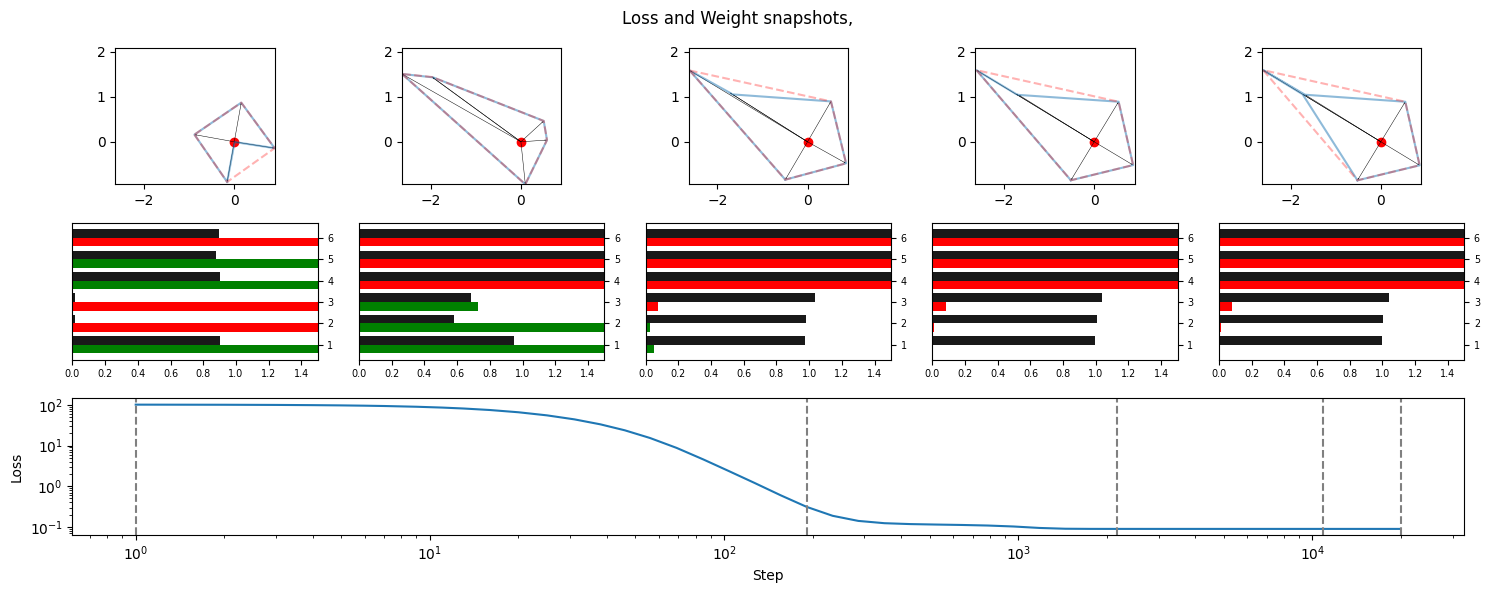

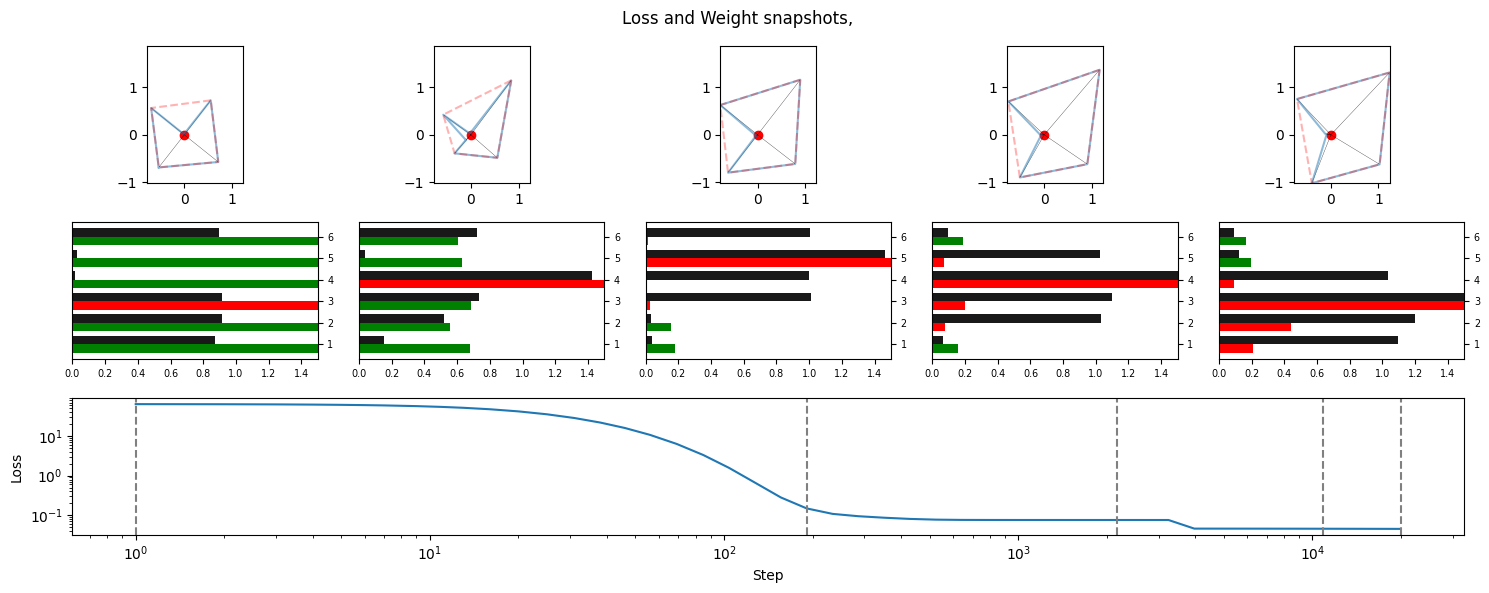

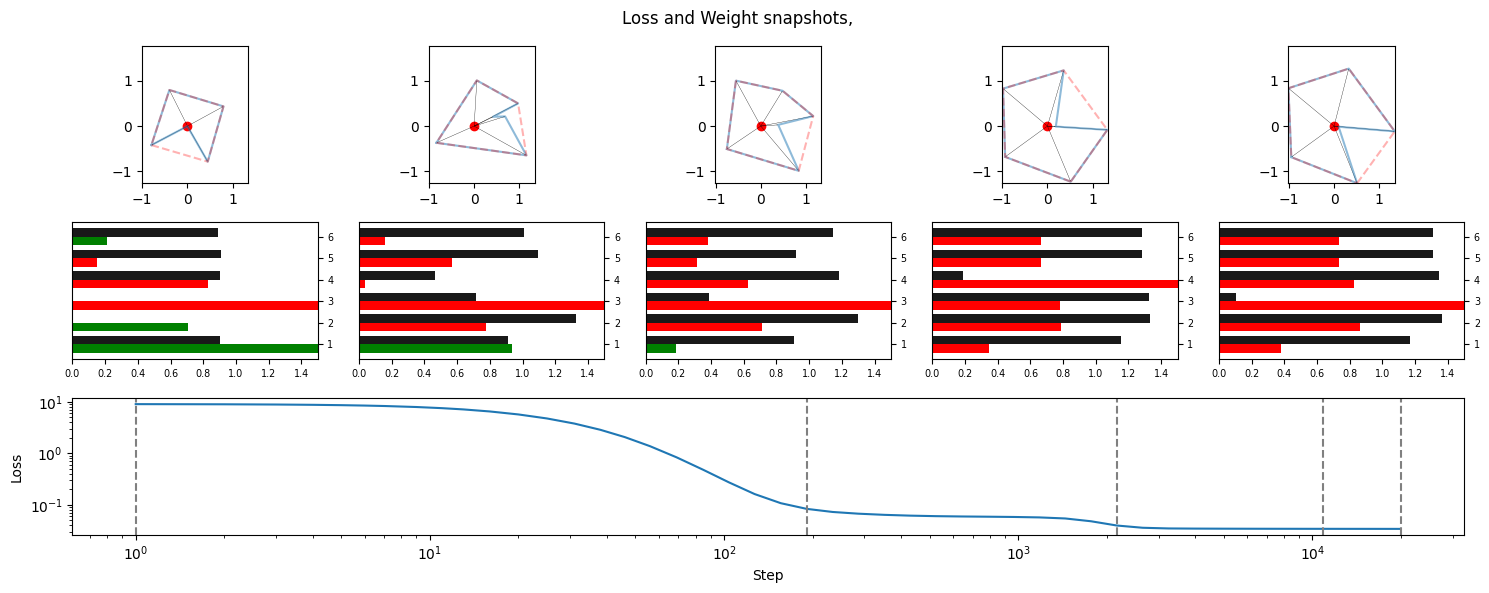

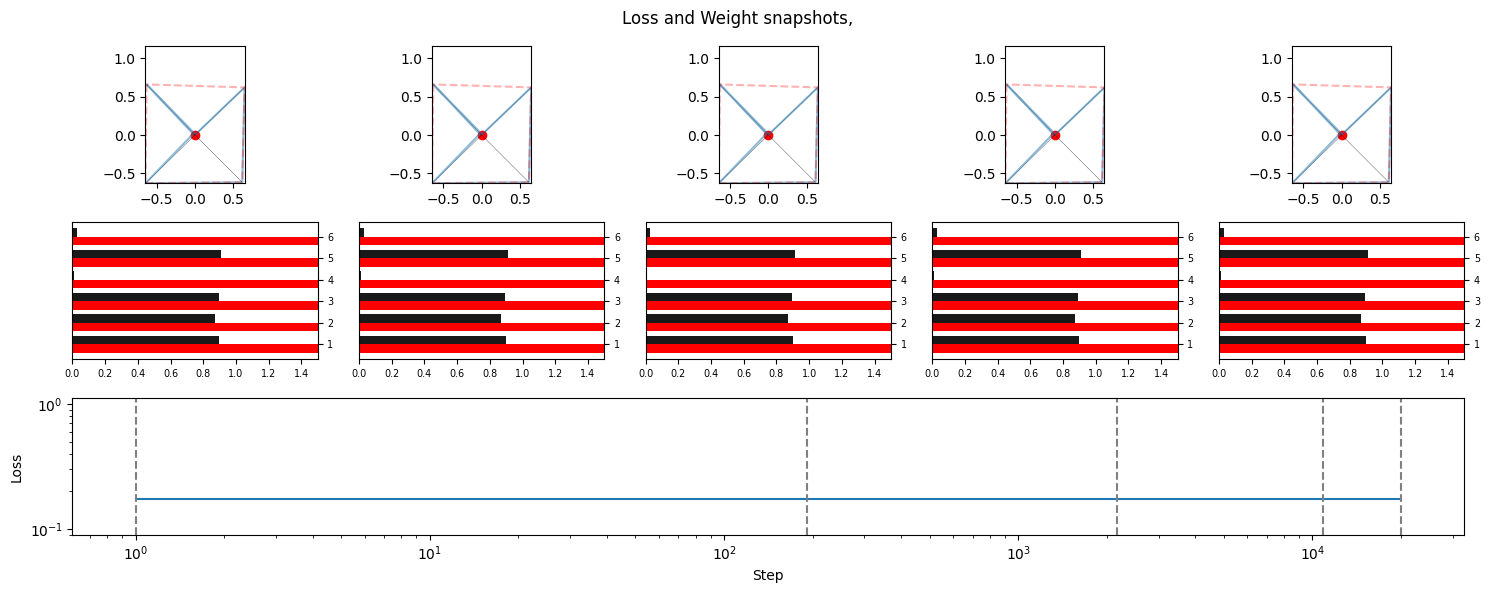

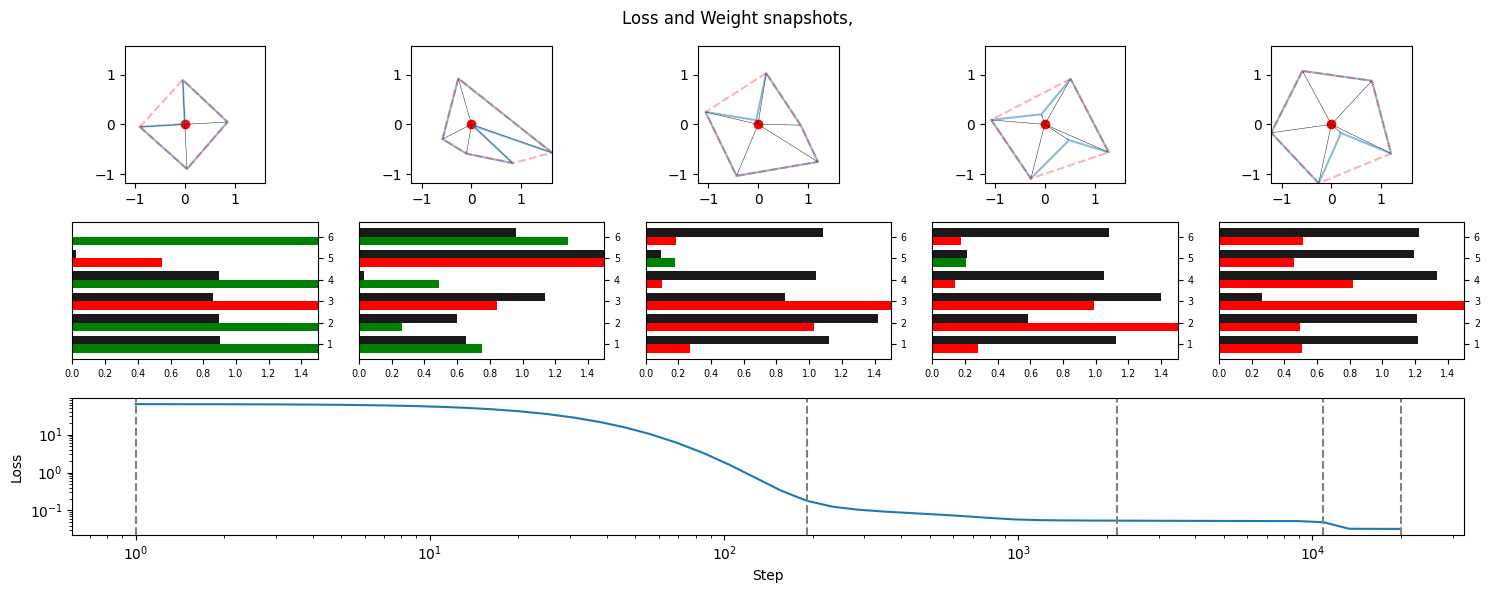

In [20]:
plot_results(results_1_13, plot_number=10, loss_window=(.000001, 1), sparsities=[0.993])

Plot polygons for sparsity=0.993


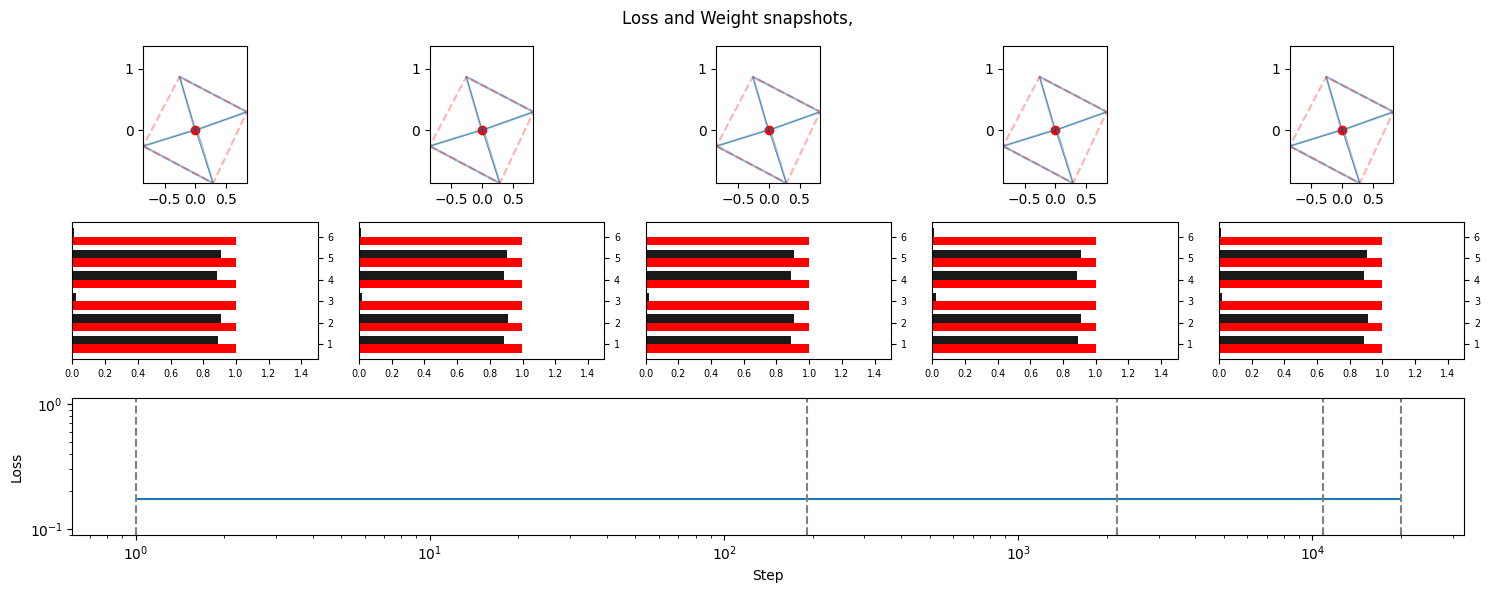

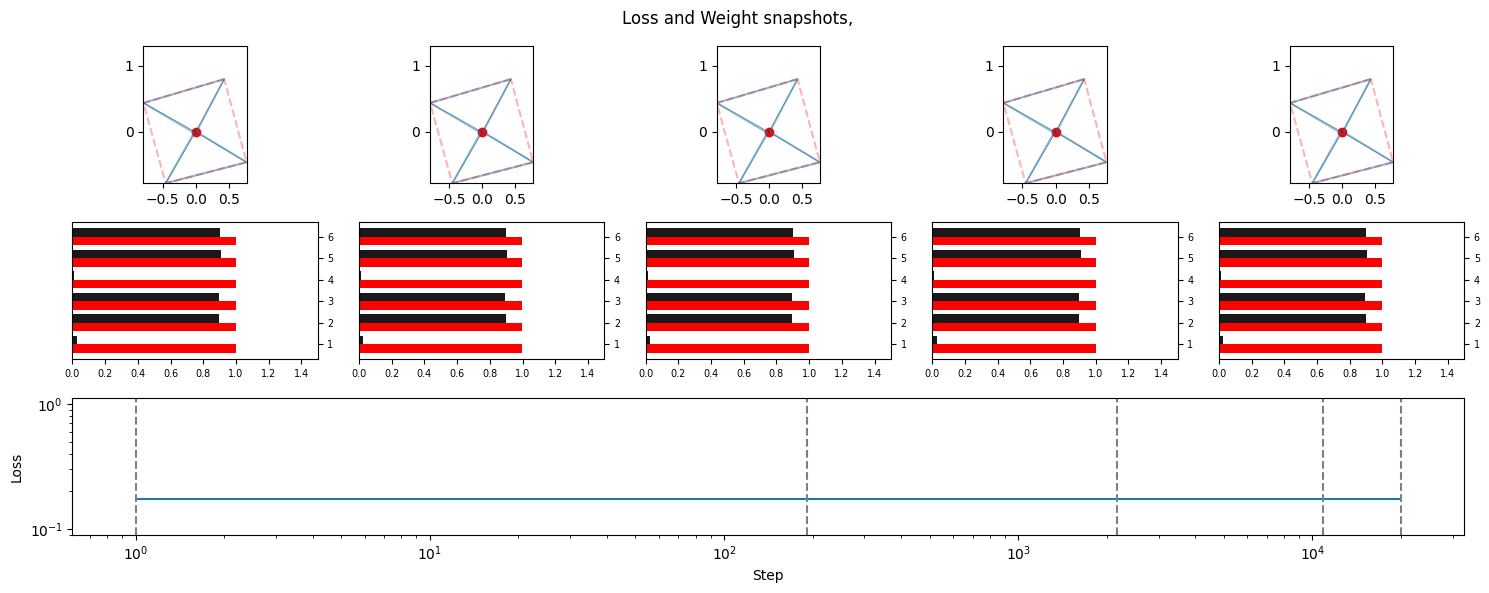

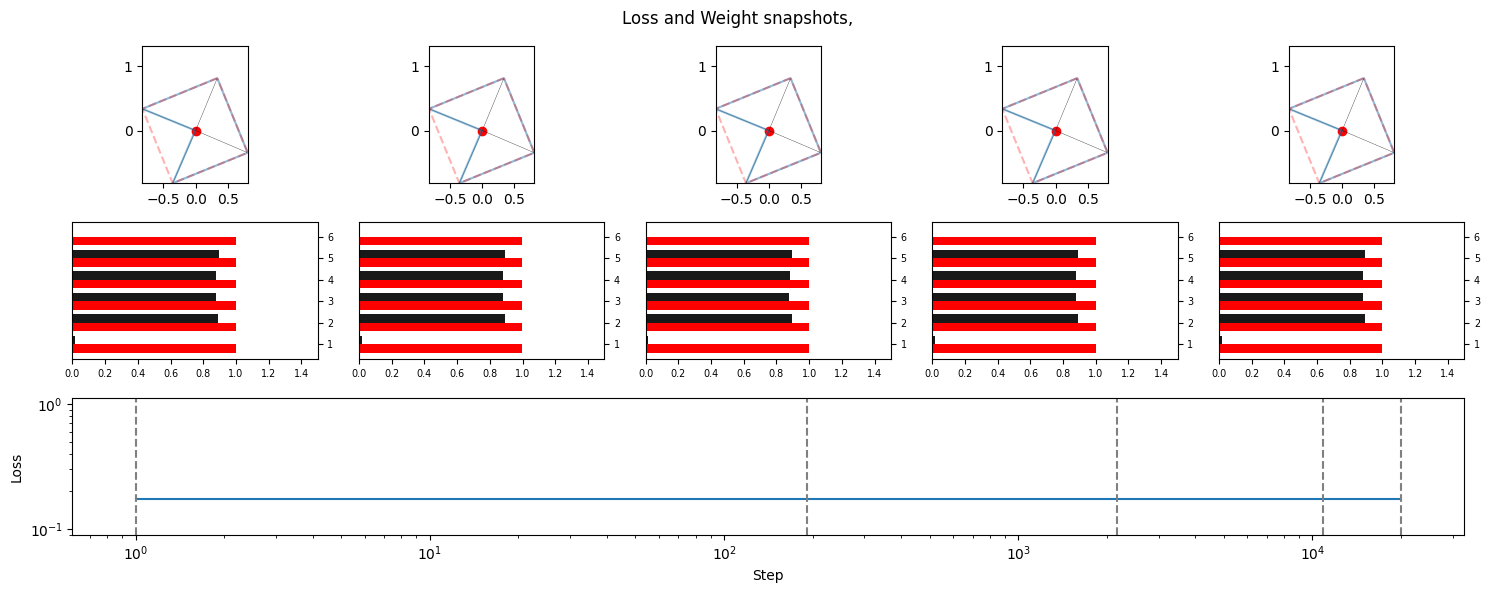

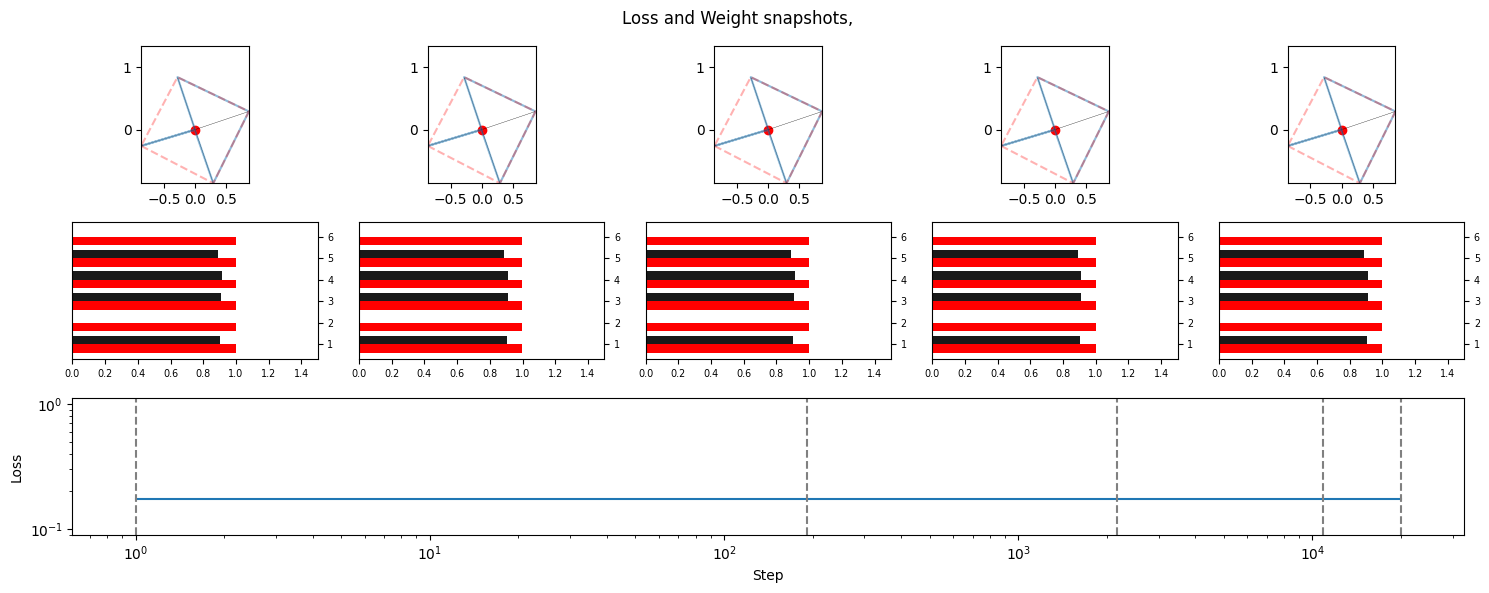

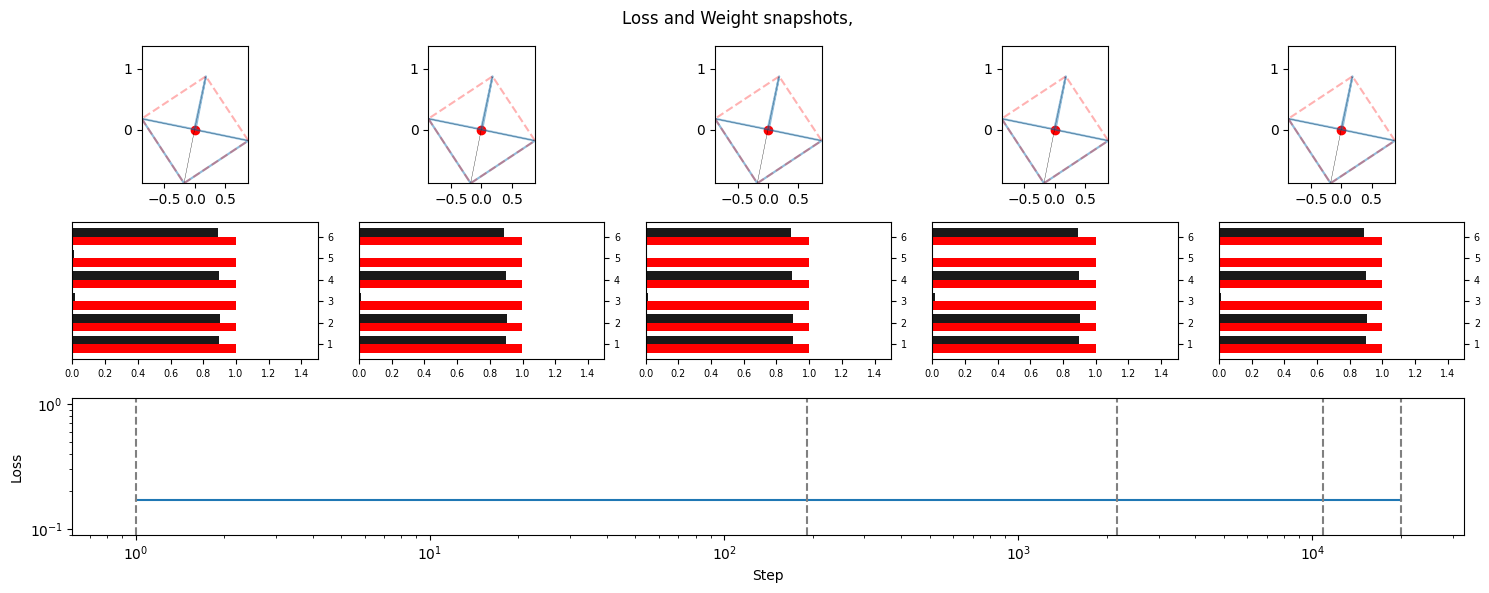

In [17]:
plot_results(results_1_14, plot_number=5, loss_window=(.000001, 1), sparsities=[0.993])

In [21]:
def calculate_convex_hull_vertices(W):

    """
    Calculate the number of vertices of the convex hull of the points represented by the columns of W.
    
    Parameters:
    W (torch.Tensor): A 2xN matrix where each column represents a point in 2D space.
    
    Returns:
    int: The number of vertices of the convex hull.
    """
    if W.shape[0] != 2:
        raise ValueError("The weight matrix W must have 2 rows.")
    
    # Convert the tensor to a numpy array if it isn't already
    if isinstance(W, torch.Tensor):
        W = W.cpu().detach().numpy()
    
    hull = ConvexHull(W.T)
    return len(hull.vertices)  # The number of vertices is the same as the number of edges

def count_kgons(W):
    edge_counts = {}
    
    # Process each weight matrix
    for full_w in W:
        num_edges = classify_kgon(full_w)
        if num_edges in edge_counts:
            edge_counts[num_edges] += 1
        else:
            edge_counts[num_edges] = 1

    return edge_counts

def classify_5_gon(W, b, differentiate_5_plus=False):
    """
    Classify a 5-gon based on the weights and biases. 
    """

    # Convert tensor to numpy if it isn't already
    if isinstance(W, torch.Tensor):
        W = W.cpu().detach().numpy()
    
    if W.shape[0] == 2:
        W = W.T

    # Compute the convex hull
    hull = ConvexHull(W)
    
    # Check if the number of vertices is equal to 5
    if len(hull.vertices) != 5:
        return "not a 5-gon"
    
    # Convert biases to a numpy array if it isn't already
    if isinstance(b, torch.Tensor):
        b = b.cpu().detach().numpy()


    # Check if any of the non-vertex biases are large negative
    non_vertex_biases = np.delete(b, hull.vertices)

    # Check for any positive bias that is not part of the convex hull vertices
    non_hull_positive_bias = np.any(non_vertex_biases > 0)

    if not non_hull_positive_bias:
        return 5
    elif non_hull_positive_bias and differentiate_5_plus:
        return "5+"
    elif non_hull_positive_bias and not differentiate_5_plus:
        return 5
    else:

        return 'not a 5-gon'



def classify_kgon(W):
    embedding_w = W["embedding.weight"]
    edges = calculate_convex_hull_vertices(embedding_w)
    if edges == 5:
        return classify_5_gon(embedding_w, W["unembedding.bias"])
    return edges

In [22]:
def calculate_kgon_percentages(results, step =-1, sparsities= [0.0, 0.426, 0.671, 0.811, 0.892, 0.938, 0.964, 0.98 , 0.988, 0.993], epsilon=0.001):
    # loss_hist = []
    for sparse_value in sparsities:
        plotted =0
        print(f"Plot polygons for sparsity={sparse_value}")
        weights = []

        STEPS = results[0]['parameters']['log_ivl']
        NUM_EPOCHS = 20000
        PLOT_STEPS = [min(STEPS, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, NUM_EPOCHS - 1]]
        PLOT_INDICES = [STEPS.index(s) for s in PLOT_STEPS]
        for PLOT_INDEX in PLOT_INDICES:
            weights = []
            for index in range(len(results)):
                non_matching_sparsity = abs(results[index]['parameters']['sparsity'] - sparse_value) > epsilon
                if non_matching_sparsity:
                    continue


                # Ws = [results[index]['weights'][i]['embedding.weight'] for i in PLOT_INDICES]
                # weights = [results[index]['weights'][i] for i in PLOT_INDICES]

                
                weights.append(results[index]['weights'][PLOT_INDEX])
            print(count_kgons(weights))

            


In [23]:
calculate_kgon_percentages(
    results_1_13,
    #k_values = [3, 4, 5, 6],
    # sparsities= [0.426],
)

Plot polygons for sparsity=0.0
{}
{}
{}
{}
{}
Plot polygons for sparsity=0.426
{4: 50}
{4: 28, 3: 10, 5: 10, 6: 2}
{4: 29, 3: 16, 5: 5}
{4: 25, 3: 18, 5: 7}
{4: 27, 3: 16, 5: 7}
Plot polygons for sparsity=0.671
{4: 50}
{4: 28, 3: 10, 5: 10, 6: 2}
{6: 2, 4: 26, 5: 4, 3: 18}
{3: 21, 4: 26, 5: 3}
{3: 27, 4: 21, 5: 2}
Plot polygons for sparsity=0.811
{4: 50}
{4: 34, 5: 9, 3: 6, 6: 1}
{3: 14, 4: 32, 5: 4}
{3: 18, 4: 31, 5: 1}
{3: 20, 4: 30}
Plot polygons for sparsity=0.892
{4: 50}
{4: 36, 5: 10, 6: 1, 3: 3}
{4: 38, 3: 3, 5: 9}
{4: 41, 5: 1, 3: 8}
{4: 40, 5: 3, 3: 7}
Plot polygons for sparsity=0.938
{4: 50}
{4: 34, 5: 12, 6: 1, 3: 3}
{4: 37, 5: 11, 3: 1, 6: 1}
{4: 43, 5: 3, 3: 4}
{4: 37, 5: 4, 3: 9}
Plot polygons for sparsity=0.964
{4: 50}
{3: 2, 4: 33, 5: 14, 6: 1}
{4: 32, 5: 15, 3: 1, 6: 2}
{4: 41, 5: 7, 3: 2}
{4: 40, 5: 7, 3: 3}
Plot polygons for sparsity=0.98
{4: 50}
{3: 1, 4: 35, 5: 13, 6: 1}
{4: 35, 5: 15}
{4: 38, 5: 9, 3: 3}
{4: 38, 5: 8, 3: 4}
Plot polygons for sparsity=0.988
{4: 50}

In [24]:
calculate_kgon_percentages(
    results_1_14,
    #k_values = [3, 4, 5, 6],
    # sparsities= [0.426],
)

Plot polygons for sparsity=0.0
{}
{}
{}
{}
{}
Plot polygons for sparsity=0.426
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}
Plot polygons for sparsity=0.671
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}
Plot polygons for sparsity=0.811
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}
Plot polygons for sparsity=0.892
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}
Plot polygons for sparsity=0.938
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}
Plot polygons for sparsity=0.964
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}
Plot polygons for sparsity=0.98
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}
Plot polygons for sparsity=0.988
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}
Plot polygons for sparsity=0.993
{4: 50}
{4: 50}
{4: 50}
{4: 50}
{4: 50}


In [ ]:
def compare_dataframes_and_results2(df_results_pairs, positions = [9, 18, 27, 36, -1], hyperparam_combos = [(300, 0.001)], x_scale="linear", y_scale="linear", sharey=False, sharex=False, ymin=1e-4, xmin=-50):
    warnings.simplefilter(action='ignore', category=UserWarning)  # Probably unwise

    for batch_size, learning_rate in hyperparam_combos:
        print(f"Batch size: {batch_size}, Learning rate: {learning_rate}\n")
        
        fig, axes = plt.subplots(len(positions), len(df_results_pairs), figsize=(15*len(df_results_pairs), 6* len(positions)), sharey=sharey, sharex=sharex)
        for i, position in enumerate(positions):
            # fig, axes = plt.subplots(1, len(df_results_pairs), figsize=(15*len(df_results_pairs), 10), sharey=sharey, sharex=sharex)
            if len(df_results_pairs) == 1:
                axes = [axes]

            for pair_index, (llc_estimates, results) in enumerate(df_results_pairs):
                llc_loss_by_sparsity = defaultdict(list)
                steps = results[0]['parameters']['log_ivl']
                
                for index in range(len(results)):
                    filtered_df = llc_estimates[llc_estimates['index'] == index]
                    llc = filtered_df[
                        (filtered_df['batch_size'] == batch_size) &
                        (filtered_df['lr'] == learning_rate) &
                        (filtered_df['snapshot_index'] == position) &
                        (filtered_df['t_sgld'] > 150) &
                        (filtered_df['llc_type'] != "mean")
                    ]["llc"].mean()
                    
                    loss = results[index]['logs']['loss'].values[position]
                    sparsity = results[index]['parameters']['sparsity']
                    llc_loss_by_sparsity[sparsity].append((llc, loss))

                for sparsity, llc_loss in llc_loss_by_sparsity.items():
                    if sparsity == 0:
                        continue
                    llcs = [llc for llc, loss in llc_loss if not(np.isnan(llc))]
                    losses = [loss for llc, loss in llc_loss if not(np.isnan(llc))]
                    if all(np.isnan(llc) for llc in llcs):
                        continue
                    axes[i,pair_index].scatter(*zip(*llc_loss), label=f"Sparsity: {round(sparsity,3)}")
                    if pair_index == 0:
                        title = "Initialized at random 4-gon"
                    if pair_index == 1:
                        title = "Initialized at optimal parameters for sparse inputs"
                    axes[i,pair_index].set_title(f"Pair {title}, Position {position}")
                    axes[i,pair_index].set_xlabel("LLC")
                    axes[i,pair_index].set_ylabel("Loss")
                    axes[i,pair_index].legend()
                    axes[i,pair_index].set_xscale(x_scale)
                    axes[i,pair_index].set_yscale(y_scale)
                    axes[i,pair_index].set_ylim(ymin=ymin)
                    axes[i,pair_index].set_xlim(xmin=xmin)


        plt.tight_layout()
        plt.suptitle(f"Loss and LLC After Epoch {steps[position]}", fontsize=16)
        plt.subplots_adjust(top=0.9)
        #plt.savefig(f'../results/loss_vs_llc_epoch_{steps[position]}')
        plt.show()

Batch size: 300, Learning rate: 0.001



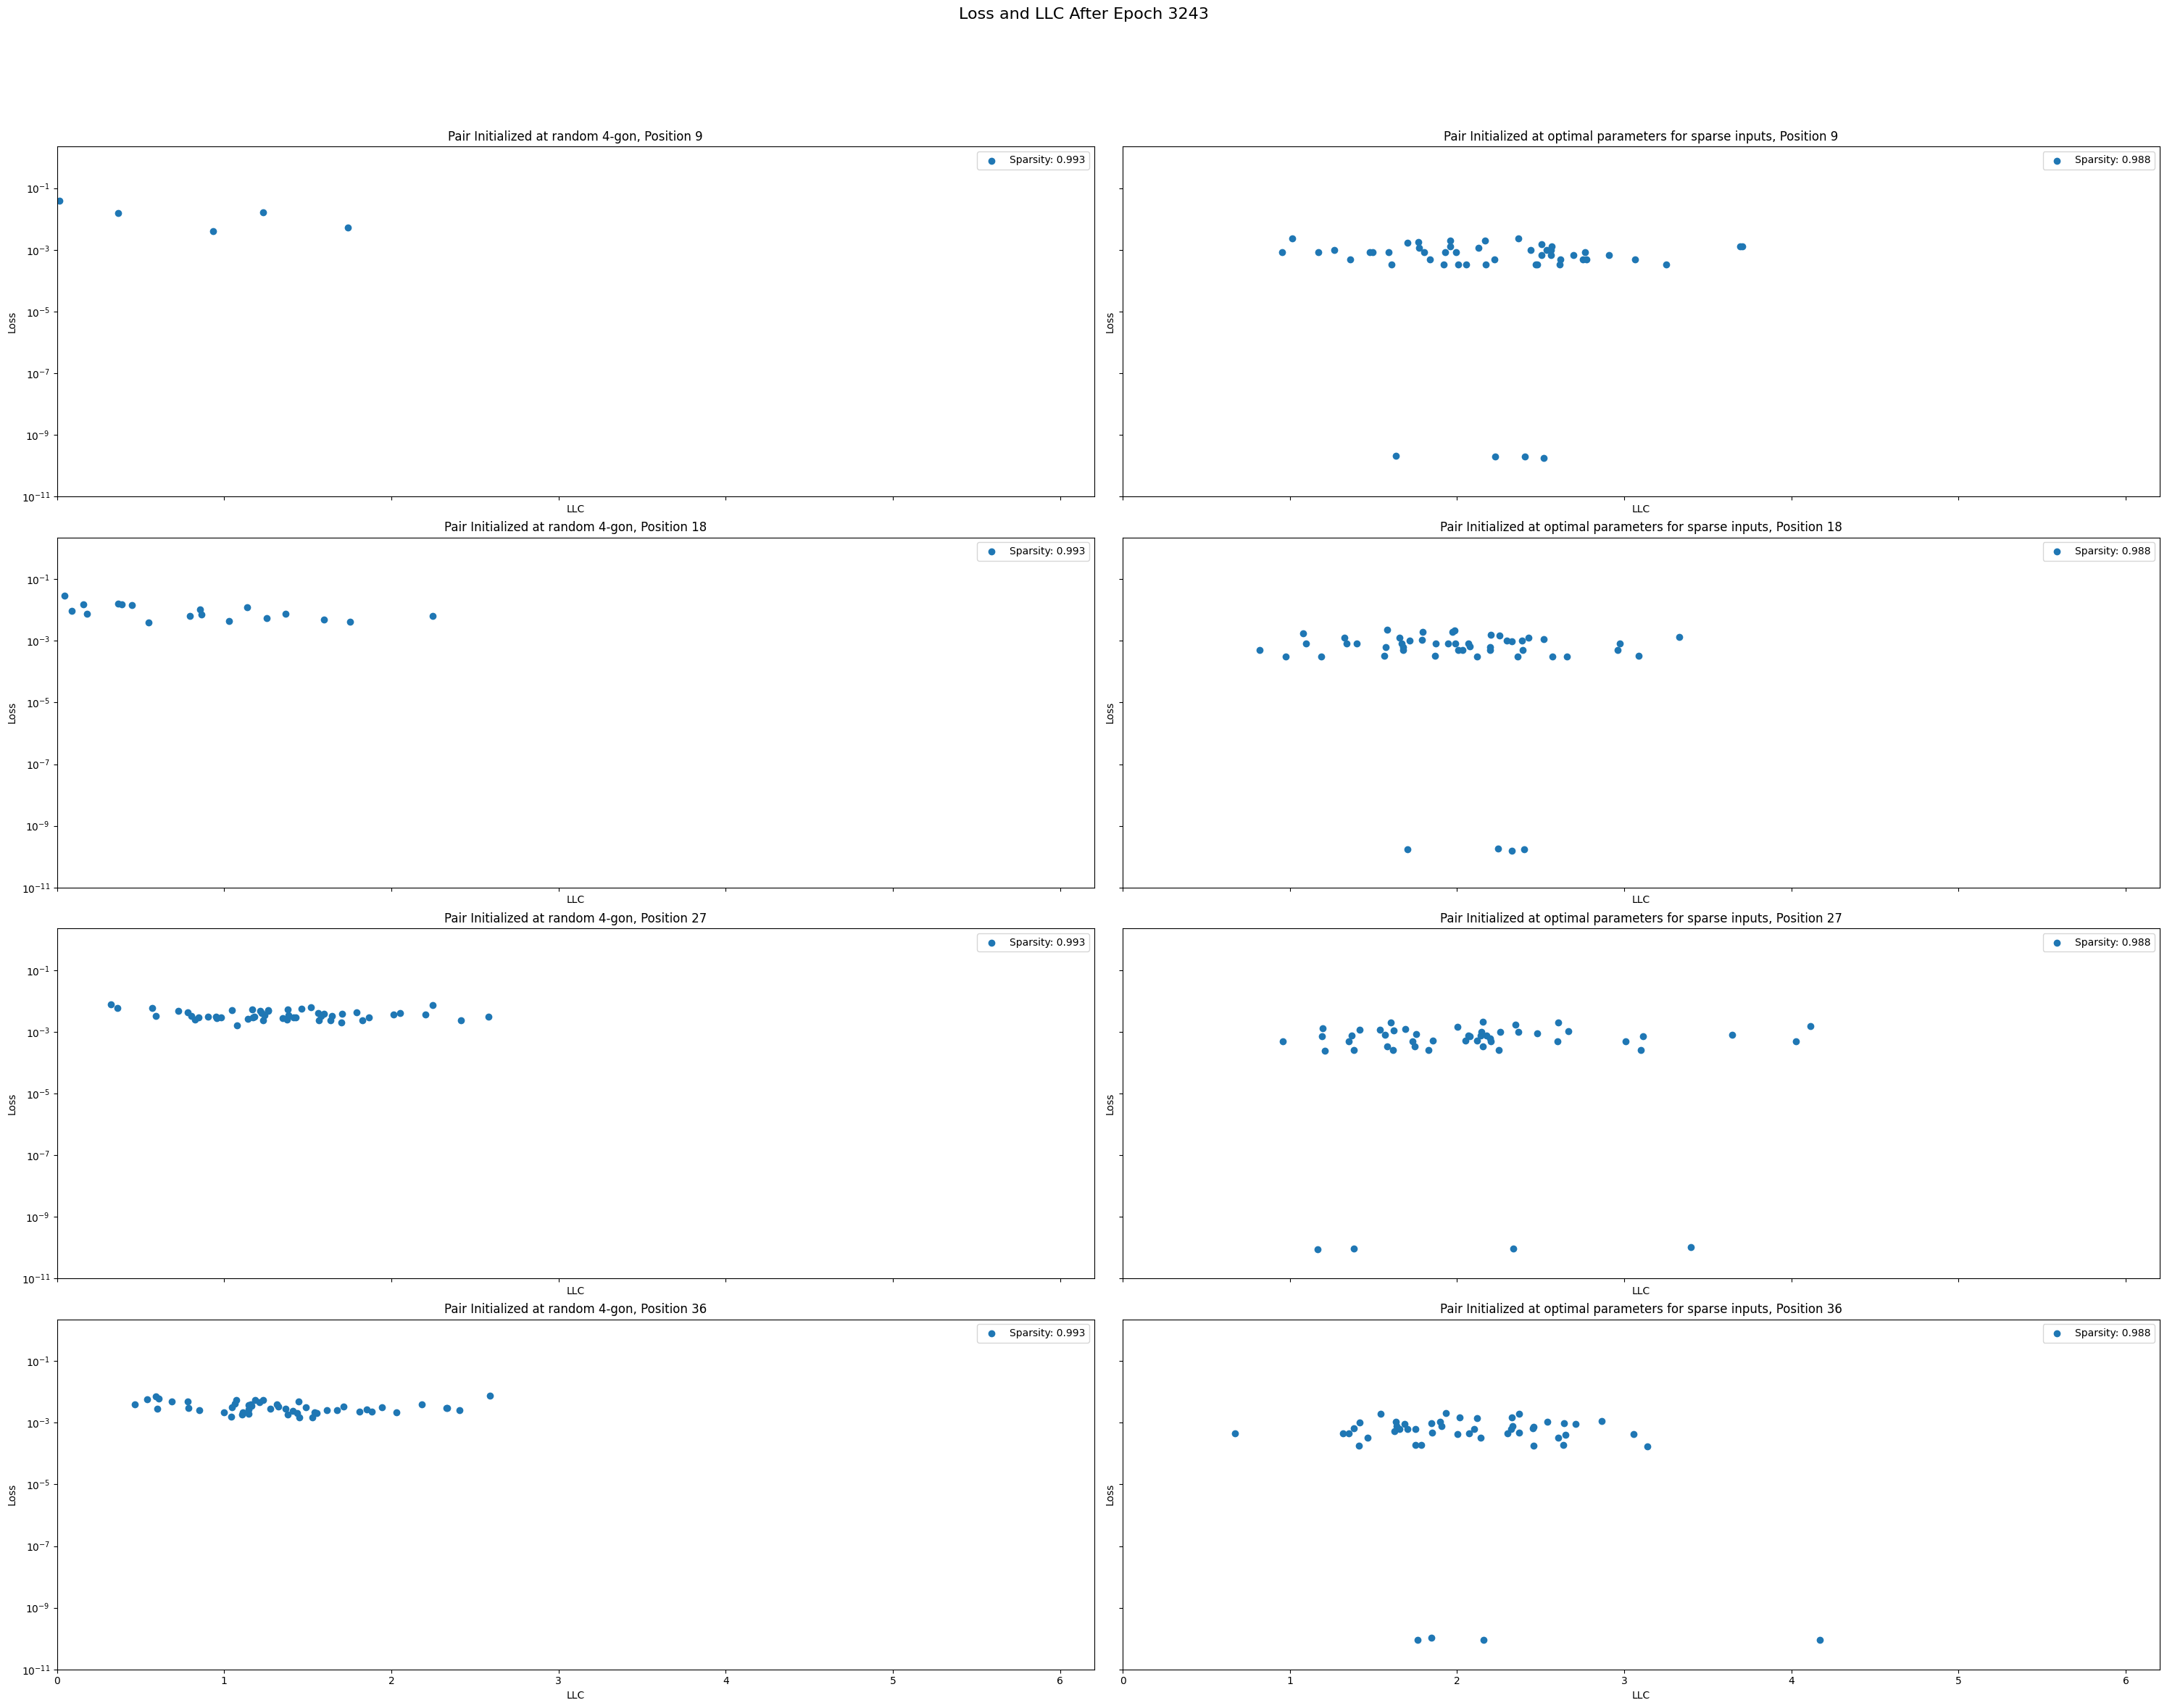

In [94]:
compare_dataframes_and_results2([(high_sparsity, results), (high_sparsity2, results2)], positions=[9, 18, 27, 36], hyperparam_combos=[(300, 0.001)], y_scale="log", sharex=True, sharey=True, ymin=1e-11, xmin=0) 